CARDAMOM Version OLD (of June 7, 2021)

Unchanged .cfb files (5 locations)

Changed DALEC 813 -> 895

Objective:

Quantative comparison of SIF/VOD impact

Metrics:
- R^2
- R
- RMSE
- Histogram intersection
- Interannual variability

In [3]:
# loading packages, setting directories

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import os
import sys
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
import datetime as dt

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error


#dircardamom = '/CARDAMOM/'
dircardamom = '/Users/olyaskulovich/GoogleDrive/from_dropbox_all/Columbia/Research/CARDAMOM/CARDAMOM/'

MACHDIR = os.path.expanduser("~")
dir_script = dircardamom +'PYTHON/cardamom_utilities/readwritebinary'
sys.path.append(dir_script)

import readwritebinary as rwbin
import readcardamommodel
import outputnames

fluxnames = outputnames.fluxnames(output='longnames')
poolnames = outputnames.poolnames(output='longnames')

#dirbinary = '/CARDAMOM/inputoutput_point/' 
dirbinary = '/Users/olyaskulovich/GoogleDrive/from_dropbox_all/Columbia/Research/CARDAMOM/inputoutput_point/' 

dir_cbf = dirbinary + 'cbf/new_rev/'
dir_cbr = dirbinary + 'cbr/new_rev/'
dir_output = dirbinary + 'output/new_rev/'
executable_assim = dircardamom + "C/projects/CARDAMOM_MDF/CARDAMOM_MDF.exe"


import processes_CARDAMOM as pC # all command line functions (compile, assimilation run, forward run)
import output_plots_CARDAMOM as Cplots # plots
import chain_coverg as GR #gelman_rubin

%matplotlib inline


In [4]:
# compile
pC.compile_CARDAMOM(dircardamom)

# Exit code = 0 means compiled without errors

The exit code was: 0
The exit code was: 0


In [3]:
def histogram_intersection(h1, h2):
    sm = 0
    for i in range(8):
        sm += min(abs(h1[i]), abs(h2[i]))
    return sm

In [4]:
from scipy.optimize import curve_fit


def seas_cycle(t, y, bounds):

    def func(x, A, period, phi, b):
        omega = 2.0 *np.pi/period
        return A * np.sin(omega * x + phi)+b
    if len(y)<20:
        y_s =np.median(y)*y/y
        print('time series is too short <20')
    else:
        try:
            popt, pcov = curve_fit(func, t, y, bounds = bounds)
            y_s = func(t, *popt)
            print('curve fit Successful')
        except:
            y_s = np.median(y)*y/y
            print( 'curve fit unsuccessful')
    return y_s

In [5]:
def HI_data(data_in, data_out, bins = 8 ):
    
    min2 = np.min(np.append(data_in, data_out))
    max2 = np.max(np.append(data_in, data_out))
    heights1, bins1 = np.histogram(data_in, bins = bins, range = [min2, max2], density = True)
    heights2, bins2 = np.histogram(data_out, bins = bins, range = [min2, max2], density = True)
    
    HI = histogram_intersection(heights1, heights2)
    return HI

In [6]:
def vod_sif_obs(nc, flux_data, basename):
    list_vod_old = ['vod_us_ha1.pkl' ,  'vod_fr_pue_old.pkl', 'vod_fr_lbr_old.pkl', 'vod_fi_hyy3.pkl', 'vod_au_how2.pkl']
    list_vod_new = ['vod_ha.pkl',  'vod_fr_pue.pkl', 'vod_fr_lbr.pkl', 'vod_fi_hyy.pkl', 'vod_au_how.pkl']
    vod_old = pd.read_pickle(list_vod_old[nc])
    vod_old['date'] = pd.to_datetime(vod_old['date'])
    vod_new = pd.read_pickle(list_vod_new[nc])
    vod_new['date'] = pd.to_datetime(vod_new['time'])
    flux_data['year'] = flux_data['TIMESTAMP'].dt.year
    flux_data['month'] = flux_data['TIMESTAMP'].dt.month
    flux_dates = flux_data[['TIMESTAMP', 'year', 'month']]

    vod_old['year'] = vod_old['date'].dt.year
    vod_old['month'] = vod_old['date'].dt.month
    vod_new['year'] = vod_new['date'].dt.year
    vod_new['month'] = vod_new['date'].dt.month
    vod = flux_dates.merge(vod_old, on = ['year', 'month'], how = 'left')
    vod = vod.merge(vod_new, on = ['year', 'month'], how = 'left')


    vod = vod.sort_values(by='TIMESTAMP')


    new_cbf = dir_cbf + six_cbfs[nc]
    new_cbr = dir_cbr + basename + '811_pure-0.cbr'
    chain = 0
    CBR_aux = pC.forward_run(dircardamom, dir_output, dir_cbr, new_cbf, new_cbr, chain )



    if (basename == 'US-Ha1') or (basename == 'FR-LBr'):
        c = 0.07
        if basename == 'US-Ha1':
            a_w = 0.000016
            a_l = 0.0002
            b = 0.42
        else:
            a_w = 0.00006
            a_l = 0.001
            b = 0.1
    elif  (basename == 'AU-How') or (basename == 'FR-Pue'):
        c = 0.11
        if basename == 'AU-How':
            a_w = 0.000001
            a_l = 0.0032
            b = 0
        else:
            a_w = 0.00005
            a_l = 0.001
            b = 0.05
    else:
        c = 0.055
        a_w = 0.00005
        a_l = 0.0013
        b = 0
    
    gpp_v = (flux_data['GPP_NT_VUT_REF'].values + flux_data['GPP_DT_VUT_REF'].values)/2
    wood = np.median(CBR_aux['POOLS'][:,:,poolnames.index('Wood C')],axis=0)
    leaves = np.median(CBR_aux['POOLS'][:,:,poolnames.index('Foliar C')],axis=0)
    
    sif = c*gpp_v
    synth = a_w*wood + a_l*leaves + b

    vod['synth'] = synth
    vod.loc[vod.str_mean.isnull(), 'synth'] = -9999
    vod.loc[vod.str_mean.isnull(), 'vod'] = -9999
    vod.loc[vod.str_mean.isnull(), 'str_mean'] = -9999
    return sif, vod

In [7]:
def change_input(cardamom_cbf, sif, vod):
    file2load =cardamom_cbf

    cbf_load = rwbin.read_cbf_file(file2load)
    ab = cbf_load['OBS']['ABGB']
    ab[np.isnan(ab)] = -9999
#nbe = cbf_load['OBS']['NBE']
#nbe[np.isnan(nbe)] = -9999
    lai = cbf_load['OBS']['LAI']
    lai[np.isnan(lai)] = -9999
    cbf_load['OBS']['LAI'] = lai
    cbf_load['OBS']['NBE'] = []
    cbf_load['OBS']['SIF'] = sif       

    cbf_load['OBS']['VOD'] = vod['str_mean'] #['synth']# 
                

    cbf_load['OBS']['ABGB'] = ab
    cbf_load['ID'] = 895 # don't forget!!!


    file2save =dir_cbf + basename  + tag+ '.cbf' 
    rwbin.CARDAMOM_WRITE_BINARY_FILEFORMAT(cbf_load, file2save)

    cardamom_cbf = file2save
    return cardamom_cbf 

In [13]:
# defining inputs and runs sequence

six_cbfs = ['US-Ha1new_data.cbf',  'FR-Puenew_data.cbf', 'FR-LBrnew_data.cbf', 'FI-Hyynew_data.cbf', 'AU-Hownew_data.cbf']
run_tags = ['none', '811_pure', '811_exp_uncopt', 'noNBE', 'SIF_synth06', 'SIF_data06', 'SIF_data_n', 'VOD_synth02', 'VOD_Xdata02', 'SIFd06+VODd']
list_flux = ['FLX_US-Ha1_FLUXNET2015.csv',  'FLX_FR-Pue_FLUXNET2015.csv',  'FLX_FR-LBr_FLUXNET2015.csv', 'FLX_FI-Hyy_FLUXNET2015.csv',  'FLX_AU-How_FLUXNET2015.csv']


for nc in range(5):
    basename = six_cbfs[nc][0:6]




# pay attention
    tag = run_tags[-1]


    cardamom_cbf = dir_cbf + six_cbfs[nc]
    cardamom_cbr = dir_cbr + basename + tag + '.cbr'




    flux_data = pd.read_csv(list_flux[nc])
    flux_data['TIMESTAMP'] = pd.to_datetime(flux_data['TIMESTAMP'], format='%Y%m')




    d0 = flux_data['TIMESTAMP'].iloc[0]

    flux_data['t']  = (flux_data['TIMESTAMP']-d0)
    flux_data['t']  = flux_data['t'].dt.days.astype('int16')

    bounds = ([0., 350., 0., 0. ], [15., 380., 2.0*np.pi, 15])
#flux
    synth_seas_cycle_nt = seas_cycle(flux_data['t'], flux_data['GPP_NT_VUT_REF'], bounds)
    dif_nt = flux_data['GPP_NT_VUT_REF']-synth_seas_cycle_nt

#flux
    synth_seas_cycle_dt = seas_cycle(flux_data['t'], flux_data['GPP_DT_VUT_REF'], bounds)
    dif_dt = flux_data['GPP_DT_VUT_REF']-synth_seas_cycle_dt


#flux
    synth_seas_cycle_nt = seas_cycle(flux_data['t'], flux_data['RECO_NT_VUT_REF'], bounds)
    dif_nt_r = flux_data['RECO_NT_VUT_REF']-synth_seas_cycle_nt

#flux
    synth_seas_cycle_dt = seas_cycle(flux_data['t'], flux_data['RECO_DT_VUT_REF'], bounds)
    dif_dt_r = flux_data['RECO_DT_VUT_REF']-synth_seas_cycle_dt
    
    
    sif, vod = vod_sif_obs(nc, flux_data, basename)
    sif = flux_data['SIF_GOME_NORM']
 
    cardamom_cbf = change_input(cardamom_cbf, sif, vod)
    cardamom_cbr = dir_cbr + basename  + tag+ '.cbr'
    
    
    
    

    all_dt = pd.DataFrame({'case': [], 'R_gpp':[],   'RMSE_gpp':[], 'R2_gpp': [], 
                      'R_reco':[],   'RMSE_reco':[], 'R2_reco': [],
                      'HI_gpp':[],   'iavm_gpp':[], 
                      'HI_reco': [], 'iavm_reco':[]})
    all_nt = pd.DataFrame({'case': [], 'R_gpp':[],   'RMSE_gpp':[], 'R2_gpp': [], 
                      'R_reco':[],   'RMSE_reco':[], 'R2_reco': [],
                      'HI_gpp':[],   'iavm_gpp':[], 
                      'HI_reco': [], 'iavm_reco':[]})
    # 'chains'
    for i in range(10):

        chain = 0
        new_cbr_c = cardamom_cbr.split('.cbr',1)[0] + '-' + str(i) + '.cbr'
       
        pC.run_CARDAMOM(dircardamom, cardamom_cbf, new_cbr_c) # number_iterations = "10000000" by default
        CBR_new = pC.forward_run(dircardamom, dir_output, dir_cbr, cardamom_cbf, new_cbr_c, chain )
    
    

        data_a = CBR_new['FLUXES'][:,:,fluxnames.index('respiration_auto (GPP -> autotrophic respiration)')]
        data_h = CBR_new['FLUXES'][:,:,fluxnames.index('respiration_het_litter (litter respiration)')]
        data_s = CBR_new['FLUXES'][:,:,fluxnames.index('respiration_het_som (SOM respiration)')]


        full_res = data_a + data_h + data_s 
        med_reco = np.median(full_res,axis=0)
    
        nt_reco =  flux_data['RECO_NT_VUT_REF']
        dt_reco =  flux_data['RECO_DT_VUT_REF']
        
    
    
        gpp_med = np.median(CBR_new['FLUXES'][:,:,fluxnames.index('GPP')],axis=0)
    
    
        nt_gpp =  flux_data['GPP_NT_VUT_REF']
        dt_gpp =  flux_data['GPP_DT_VUT_REF']
    
        HI_gpp_nt = HI_data(nt_gpp, gpp_med ) 
        HI_reco_nt = HI_data(nt_reco, med_reco ) 
    
        HI_gpp_dt = HI_data(dt_gpp, gpp_med ) 
        HI_reco_dt = HI_data(dt_reco, med_reco ) 
    
        synth_seas_cycle = seas_cycle(flux_data['t'], gpp_med, bounds)
        dif_gpp_m = gpp_med- synth_seas_cycle


        gpp_nt_m = np.sum(dif_gpp_m**2)/np.sum(dif_nt**2)
        gpp_dt_m = np.sum(dif_gpp_m**2)/np.sum(dif_dt**2)
    
    
        synth_seas_cycle_r = seas_cycle(flux_data['t'], med_reco, bounds)
        dif_reco_m = med_reco- synth_seas_cycle_r


        reco_nt_m = np.sum(dif_reco_m**2)/np.sum(dif_nt_r**2)
        reco_dt_m = np.sum(dif_reco_m**2)/np.sum(dif_dt_r**2)

              
        this_dt = pd.DataFrame({'case': [tag], 'R_gpp':[np.corrcoef(gpp_med, dt_gpp)[0][1]],  
                            'RMSE_gpp':[mean_squared_error(dt_gpp, gpp_med, squared=False)],
                            'R2_gpp': [r2_score( dt_gpp, gpp_med)], 
                      'R_reco':[np.corrcoef(med_reco, dt_reco)[0][1]],  
                            'RMSE_reco':[mean_squared_error(dt_reco, med_reco, squared=False)], 
                            'R2_reco': [r2_score( dt_reco, med_reco)],
                      'HI_gpp':[HI_gpp_dt],   'iavm_gpp':[gpp_dt_m], 
                      'HI_reco': [HI_reco_dt], 'iavm_reco':[reco_dt_m]})
        all_dt = pd.concat([all_dt, this_dt], ignore_index=True)
        this_nt = pd.DataFrame({'case': [tag], 'R_gpp':[np.corrcoef(gpp_med, nt_gpp)[0][1]],   
                            'RMSE_gpp':[mean_squared_error(nt_gpp, gpp_med, squared=False)], 
                            'R2_gpp': r2_score( nt_gpp, gpp_med), 
                      'R_reco':[np.corrcoef(med_reco, nt_reco)[0][1]],  
                            'RMSE_reco':[mean_squared_error(nt_reco, med_reco, squared=False)], 
                            'R2_reco': [r2_score( nt_reco, med_reco)],
                      'HI_gpp':[HI_gpp_nt],   'iavm_gpp':[gpp_nt_m], 
                      'HI_reco': [HI_reco_nt], 'iavm_reco': [reco_nt_m]})
        all_nt = pd.concat([all_nt, this_nt], ignore_index=True)
    all_dt              
    whereto = '_revision'

    try:
        all_nt_past = pd.read_csv(basename + whereto + '_all_nt.csv')
        all_nt_past = pd.concat([all_nt_past, all_nt], ignore_index=True)
        all_nt_past.to_csv(basename+ whereto + '_all_nt.csv',  index=False)
    
        all_dt_past = pd.read_csv(basename + whereto + '_all_dt.csv')
        all_dt_past = pd.concat([all_dt_past, all_dt], ignore_index=True)
        all_dt_past.to_csv(basename+ whereto + '_all_dt.csv',  index=False)
    except:
        all_nt.to_csv(basename+ whereto + '_all_nt.csv',  index=False)
        all_dt.to_csv(basename+ whereto + '_all_dt.csv',  index=False)

curve fit Successful
curve fit Successful
curve fit Successful
curve fit Successful
OKCHECK:CHECK: DATA structure successfully initialized
about to declare EDCD
DALECmodel.EDCD = 0x0
EDCD->EQF = 2.00
done with declaration
DALECmodel.EDCD->EQF = 2.00
DATA->nodays = 180
DATA->nofluxes = 30
nee annual unc = -9999.000000
nee obs unc = 1.000000
lai other prior = -9999.000000
lai other unc = 0.568798
reading file...
No prescribed met reference means, calculating based on driver data
frf = 0
***CBF FILE SUMMARY***MODEL ID = 811
No days = 180
Mean Rad = 13.245573
Mean Temp = 8.297143
Mean Prec = 3.241389
Latitude = 43.000000
Number of MET drivers9
Number of GPP obs. = 0
Number of LAI obs. = 151
Number of NEE obs. = 156
Number of EWT obs. = 0
Number of CH4 obs. = 0
Number of SIF obs. = 0
Number of VOD obs. = 0
Number of obs. = 13
Ecological & Dynamic Constraints options
EDC likelihood option = 1
EDC diagnostics option = 0
*****END OF CBF FILE SUMMARY***number of parvecs to run = 10000
The exit 

starting likelihood = -5.000000e+01
Total iterations (out of 100000) = 10000
Total within range = 73.750%
Total Accepted = 1083
Local Acceptance rate (acc,accloc,mco.nadapt) 0.0% (    1083,     1000,       10)
Log Likelihood -2.000000e+01
Mean step size (amp) = 0.07075(1.00000)
Total iterations (out of 100000) = 20000
Total within range = 76.950%
Total Accepted = 1672
Local Acceptance rate (acc,accloc,mco.nadapt) 0.0% (    1672,     2000,       10)
Log Likelihood -2.000000e+01
Mean step size (amp) = 0.09304(1.00000)
Total iterations (out of 100000) = 30000
Total within range = 73.020%
Total Accepted = 2237
Local Acceptance rate (acc,accloc,mco.nadapt) 0.0% (    2237,     3000,       10)
Log Likelihood -1.500000e+01
Mean step size (amp) = 0.12358(1.00000)
Total iterations (out of 100000) = 40000
Total within range = 68.680%
Total Accepted = 2657
Local Acceptance rate (acc,accloc,mco.nadapt) 10.0% (    2657,     4000,       10)
Log Likelihood -1.500000e+01
Mean step size (amp) = 0.11449(

starting likelihood = -6.778623e+02
MHMCMC DONE
completed MHMCMC 119
MCMC complete
The exit code was: 0
OKCHECK:CHECK: DATA structure successfully initialized
about to declare EDCD
DALECmodel.EDCD = 0x0
EDCD->EQF = 2.00
done with declaration
DALECmodel.EDCD->EQF = 2.00
DATA->nodays = 180
DATA->nofluxes = 30
nee annual unc = -9999.000000
nee obs unc = 1.000000
lai other prior = -9999.000000
lai other unc = 0.568798
reading file...
No prescribed met reference means, calculating based on driver data
frf = 0
***CBF FILE SUMMARY***MODEL ID = 895
No days = 180
Mean Rad = 13.245573
Mean Temp = 8.297143
Mean Prec = 3.241389
Latitude = 43.000000
Number of MET drivers9
Number of GPP obs. = 0
Number of LAI obs. = 151
Number of NEE obs. = 0
Number of EWT obs. = 0
Number of CH4 obs. = 0
Number of SIF obs. = 71
Number of VOD obs. = 113
Number of obs. = 13
Ecological & Dynamic Constraints options
EDC likelihood option = 1
EDC diagnostics option = 0
*****END OF CBF FILE SUMMARY***number of parvecs to 

starting likelihood = -5.500000e+01
Total iterations (out of 100000) = 10000
Total within range = 71.580%
Total Accepted = 1544
Local Acceptance rate (acc,accloc,mco.nadapt) 10.0% (    1544,     1000,       10)
Log Likelihood -1.500000e+01
Mean step size (amp) = 0.07322(1.00000)
Total iterations (out of 100000) = 20000
Total within range = 76.060%
Total Accepted = 2420
Local Acceptance rate (acc,accloc,mco.nadapt) 20.0% (    2420,     2000,       10)
Log Likelihood -1.000000e+01
Mean step size (amp) = 0.09171(1.00000)
Total iterations (out of 100000) = 30000
Total within range = 72.800%
Total Accepted = 2901
Local Acceptance rate (acc,accloc,mco.nadapt) 0.0% (    2901,     3000,       10)
Log Likelihood -0.000000e+00
Mean step size (amp) = 0.09347(1.00000)
Total iterations (out of 100000) = 40000
Total within range = 74.020%
Total Accepted = 3317
Local Acceptance rate (acc,accloc,mco.nadapt) 0.0% (    3317,     4000,       10)
Log Likelihood -0.000000e+00
Mean step size (amp) = 0.11097

starting likelihood = -6.000000e+01
Total iterations (out of 100000) = 10000
Total within range = 67.930%
Total Accepted = 1495
Local Acceptance rate (acc,accloc,mco.nadapt) 0.0% (    1495,     1000,       10)
Log Likelihood -3.000000e+01
Mean step size (amp) = 0.07292(1.00000)
Total iterations (out of 100000) = 20000
Total within range = 67.350%
Total Accepted = 2751
Local Acceptance rate (acc,accloc,mco.nadapt) 0.0% (    2751,     2000,       10)
Log Likelihood -2.000000e+01
Mean step size (amp) = 0.13503(1.00000)
Total iterations (out of 100000) = 30000
Total within range = 63.460%
Total Accepted = 3268
Local Acceptance rate (acc,accloc,mco.nadapt) 0.0% (    3268,     3000,       10)
Log Likelihood -1.500000e+01
Mean step size (amp) = 0.13913(1.00000)
Total iterations (out of 100000) = 40000
Total within range = 67.820%
Total Accepted = 3836
Local Acceptance rate (acc,accloc,mco.nadapt) 0.0% (    3836,     4000,       10)
Log Likelihood -1.000000e+01
Mean step size (amp) = 0.12694(1

starting likelihood = -7.166514e+02
MHMCMC DONE
completed MHMCMC 119
MCMC complete
The exit code was: 0
OKCHECK:CHECK: DATA structure successfully initialized
about to declare EDCD
DALECmodel.EDCD = 0x0
EDCD->EQF = 2.00
done with declaration
DALECmodel.EDCD->EQF = 2.00
DATA->nodays = 180
DATA->nofluxes = 30
nee annual unc = -9999.000000
nee obs unc = 1.000000
lai other prior = -9999.000000
lai other unc = 0.568798
reading file...
No prescribed met reference means, calculating based on driver data
frf = 0
***CBF FILE SUMMARY***MODEL ID = 895
No days = 180
Mean Rad = 13.245573
Mean Temp = 8.297143
Mean Prec = 3.241389
Latitude = 43.000000
Number of MET drivers9
Number of GPP obs. = 0
Number of LAI obs. = 151
Number of NEE obs. = 0
Number of EWT obs. = 0
Number of CH4 obs. = 0
Number of SIF obs. = 71
Number of VOD obs. = 113
Number of obs. = 13
Ecological & Dynamic Constraints options
EDC likelihood option = 1
EDC diagnostics option = 0
*****END OF CBF FILE SUMMARY***number of parvecs to 

starting likelihood = -7.000000e+01
Total iterations (out of 100000) = 10000
Total within range = 74.040%
Total Accepted = 1732
Local Acceptance rate (acc,accloc,mco.nadapt) 40.0% (    1732,     1000,       10)
Log Likelihood -3.500000e+01
Mean step size (amp) = 0.08864(1.00000)
Total iterations (out of 100000) = 20000
Total within range = 71.230%
Total Accepted = 2697
Local Acceptance rate (acc,accloc,mco.nadapt) 0.0% (    2697,     2000,       10)
Log Likelihood -2.000000e+01
Mean step size (amp) = 0.10235(1.00000)
Total iterations (out of 100000) = 30000
Total within range = 76.330%
Total Accepted = 2958
Local Acceptance rate (acc,accloc,mco.nadapt) 0.0% (    2958,     3000,       10)
Log Likelihood -2.000000e+01
Mean step size (amp) = 0.07125(1.00000)
Total iterations (out of 100000) = 40000
Total within range = 72.210%
Total Accepted = 3385
Local Acceptance rate (acc,accloc,mco.nadapt) 0.0% (    3385,     4000,       10)
Log Likelihood -1.500000e+01
Mean step size (amp) = 0.10810(

curve fit Successful
curve fit Successful
OKCHECK:MDF options structure read successfully
Seed number = 3860229
OKCHECK:Main data structure initialized
about to declare EDCD
DALECmodel.EDCD = 0x0
EDCD->EQF = 2.00
done with declaration
DALECmodel.EDCD->EQF = 2.00
DATA->nodays = 180
DATA->nofluxes = 30
nee annual unc = -9999.000000
nee obs unc = 1.000000
lai other prior = -9999.000000
lai other unc = 0.568798
reading file...
No prescribed met reference means, calculating based on driver data
frf = 0
***CBF FILE SUMMARY***MODEL ID = 895
No days = 180
Mean Rad = 13.245573
Mean Temp = 8.297143
Mean Prec = 3.241389
Latitude = 43.000000
Number of MET drivers9
Number of GPP obs. = 0
Number of LAI obs. = 151
Number of NEE obs. = 0
Number of EWT obs. = 0
Number of CH4 obs. = 0
Number of SIF obs. = 71
Number of VOD obs. = 113
Number of obs. = 13
Ecological & Dynamic Constraints options
EDC likelihood option = 1
EDC diagnostics option = 0
*****END OF CBF FILE SUMMARY***OKCHECK:Main data structure 

starting likelihood = -6.000000e+01
Total iterations (out of 100000) = 10000
Total within range = 75.560%
Total Accepted = 1577
Local Acceptance rate (acc,accloc,mco.nadapt) 10.0% (    1577,     1000,       10)
Log Likelihood -2.000000e+01
Mean step size (amp) = 0.09145(1.00000)
Total iterations (out of 100000) = 20000
Total within range = 71.730%
Total Accepted = 2021
Local Acceptance rate (acc,accloc,mco.nadapt) 0.0% (    2021,     2000,       10)
Log Likelihood -1.500000e+01
Mean step size (amp) = 0.09321(1.00000)
Total iterations (out of 100000) = 30000
Total within range = 65.980%
Total Accepted = 2248
Local Acceptance rate (acc,accloc,mco.nadapt) 0.0% (    2248,     3000,       10)
Log Likelihood -1.000000e+01
Mean step size (amp) = 0.06027(1.00000)
Total iterations (out of 100000) = 40000
Total within range = 73.070%
Total Accepted = 2539
Local Acceptance rate (acc,accloc,mco.nadapt) 10.0% (    2539,     4000,       10)
Log Likelihood -1.000000e+01
Mean step size (amp) = 0.07235

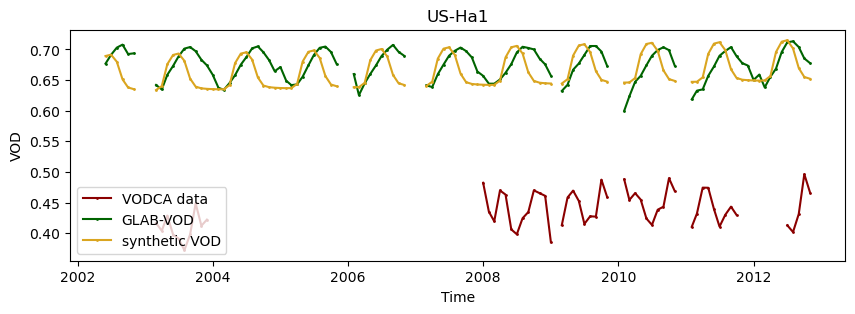

In [19]:
fig = plt.figure(figsize=(10, 3))


plt.plot(vod['TIMESTAMP'], vod['vod'], marker = 'o', color = 'darkred', ms = 1, label = 'VODCA data ')
plt.plot(vod['TIMESTAMP'], vod['str_mean'], marker = 'o', color = 'darkgreen', ms = 1, label = 'GLAB-VOD')


plt.plot(vod['TIMESTAMP'], vod['synth'], marker = 'o', color = 'goldenrod', ms = 1, label = 'synthetic VOD')


plt.title(basename)
plt.xlabel('Time')
plt.ylabel('VOD')
plt.legend(loc = 'lower left')
plt.show()

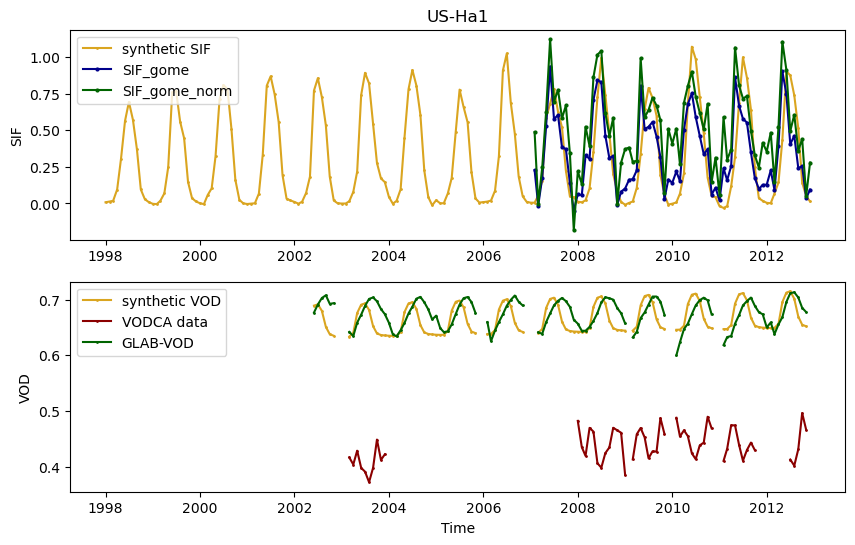

In [20]:
fig = plt.figure(figsize=(10, 6))
flux_cl = flux_data[flux_data['SIF_GOME']>-9999]

ax = fig.add_subplot(2, 1, 1)

plt.plot(flux_data['TIMESTAMP'], sif, marker = 'o', color = 'goldenrod', ms = 1, label = 'synthetic SIF')
plt.plot(flux_cl['TIMESTAMP'], flux_cl['SIF_GOME'], marker = 'o', color = 'darkblue', ms = 2, label = 'SIF_gome')
plt.plot(flux_cl['TIMESTAMP'], flux_cl['SIF_GOME_NORM'], marker = 'o', color = 'darkgreen', ms = 2, label = 'SIF_gome_norm')


plt.legend()
plt.title(basename)
plt.ylabel('SIF')

limits = ax.get_xlim()

ax = fig.add_subplot(2, 1, 2)
plt.plot(vod['TIMESTAMP'], vod['synth'], marker = 'o', color = 'goldenrod', ms = 1, label = 'synthetic VOD')

plt.plot(vod['TIMESTAMP'], vod['vod'], marker = 'o', color = 'darkred', ms = 1, label = 'VODCA data ')
plt.plot(vod['TIMESTAMP'], vod['str_mean'], marker = 'o', color = 'darkgreen', ms = 1, label = 'GLAB-VOD')

ax.set_xlim(limits)


plt.xlabel('Time')
plt.ylabel('VOD')
plt.legend()


#plt.savefig('US_sif_vod_data.pdf', bbox_inches='tight')

plt.show()

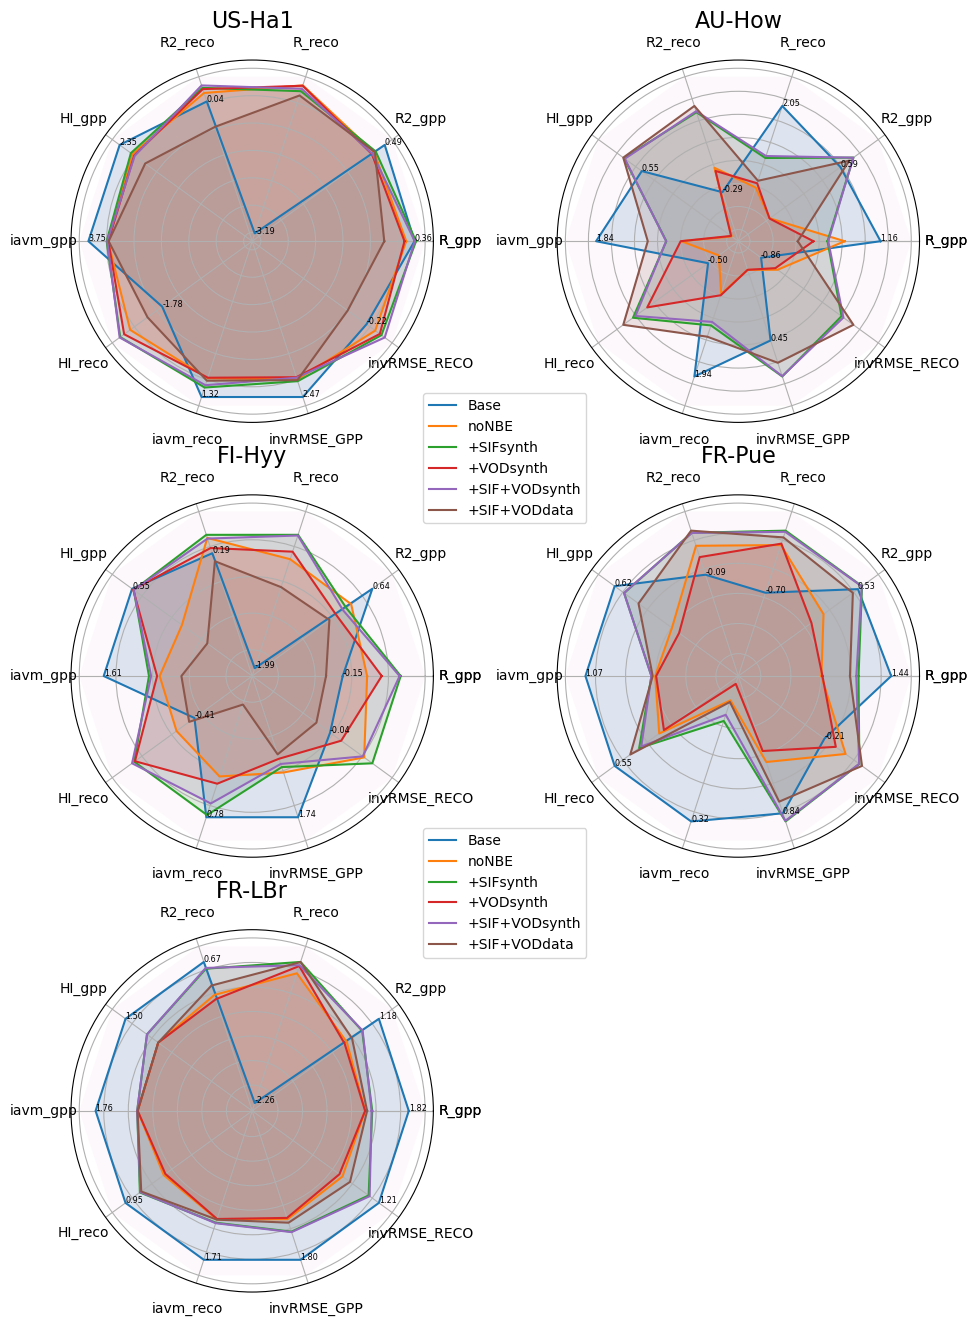

In [26]:
def spider2(df, *, id_column, title=None, max_values=None, padding=1.25, flag):
    categories = df._get_numeric_data().columns.tolist()
    data = df[categories].to_dict(orient='list')
    ids = df[id_column].tolist()
    if max_values is None:
        max_values = {key: padding*max(value) for key, value in data.items()}
        
    normalized_data = {key: np.array(value) / max_values[key] for key, value in data.items()}
    num_vars = len(data.keys())
    tiks = list(data.keys())
    tiks += tiks[:1]
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist() + [0]
    #fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))
    for i, model_name in enumerate(ids):
        values = [normalized_data[key][i] for key in data.keys()]
        actual_values = [data[key][i] for key in data.keys()]
        values += values[:1]  # Close the plot for a better look
        ax.plot(angles, values, label=model_name)
        ax.fill(angles, values, alpha=0.15)
        
        if (i==0) or (i==len(ids)):

            for _x, _y, t in zip(angles, values, actual_values):
                
                t = f'{t:.2f}' if isinstance(t, float) else str(t)
                ax.text(_x, _y, t, size='xx-small')
            
    ax.fill(angles, np.ones(num_vars + 1), alpha=0.05)
    ax.set_yticklabels([])
    ax.set_xticks(angles)
    ax.set_xticklabels(tiks)
    ax.tick_params(axis='both', which='major', pad=9)
    if flag:
        ax.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
    if title is not None: plt.title(title, fontsize = 16)
    #plt.show()
radar = spider2    
sites = [ 'US-Ha1', 'AU-How',  'FI-Hyy','FR-Pue', 'FR-LBr']
fig = plt.figure(figsize=(11.5, 16))
for i, site in enumerate(sites):
    if (i==1) or (i==3):
        flag = True
    else:
        flag = False
    data1 = site + '_revision_all_dt.csv'
    data = pd.read_csv(data1)
    data['invRMSE_GPP'] = 1/data['RMSE_gpp']
    data['invRMSE_RECO'] = 1/data['RMSE_reco']
    data = data.drop(['RMSE_reco', 'RMSE_gpp'], axis=1)
    
    df = data.drop(columns=['case'])
    col_names = df.columns
    for cl in col_names:
        data[cl] = (data[cl]-np.mean(data[cl]))/np.std(data[cl])

    data_group = data.groupby('case').mean().reset_index()
    
    data_group = data_group[data_group['case'].isin(['811_exp_uncopt', 'noNBE', 'SIF_synth06', 'VOD_synth02', 'SIF+VOD', 'SIFd06+VODd'])]
    data_group.loc[data_group['case'] == "SIF_synth06", "case"] = '+SIFsynth'
    data_group.loc[data_group['case'] == "811_exp_uncopt", "case"] = 'Base'
    data_group.loc[data_group['case'] == "VOD_synth02", "case"] = '+VODsynth'
    data_group.loc[data_group['case'] == "SIF+VOD", "case"] = '+SIF+VODsynth'
    data_group.loc[data_group['case'] == "SIFd06+VODd", "case"] = '+SIF+VODdata'
    custom_order = ['Base', 'noNBE', '+SIFsynth', '+VODsynth', '+SIF+VODsynth', '+SIF+VODdata']

# Convert 'case' column to categorical with the specified order
    data_group['case'] = pd.Categorical(data_group['case'], categories=custom_order, ordered=True)


    data_group = data_group.sort_values(by='case')

    ax = fig.add_subplot(3, 2, i+1, polar=True)
#print(data)
    spider2(
        data_group,
        id_column='case',
        title=site,
        padding=1.5,
        flag = flag)
plt.savefig('main_extended.pdf', bbox_inches='tight')

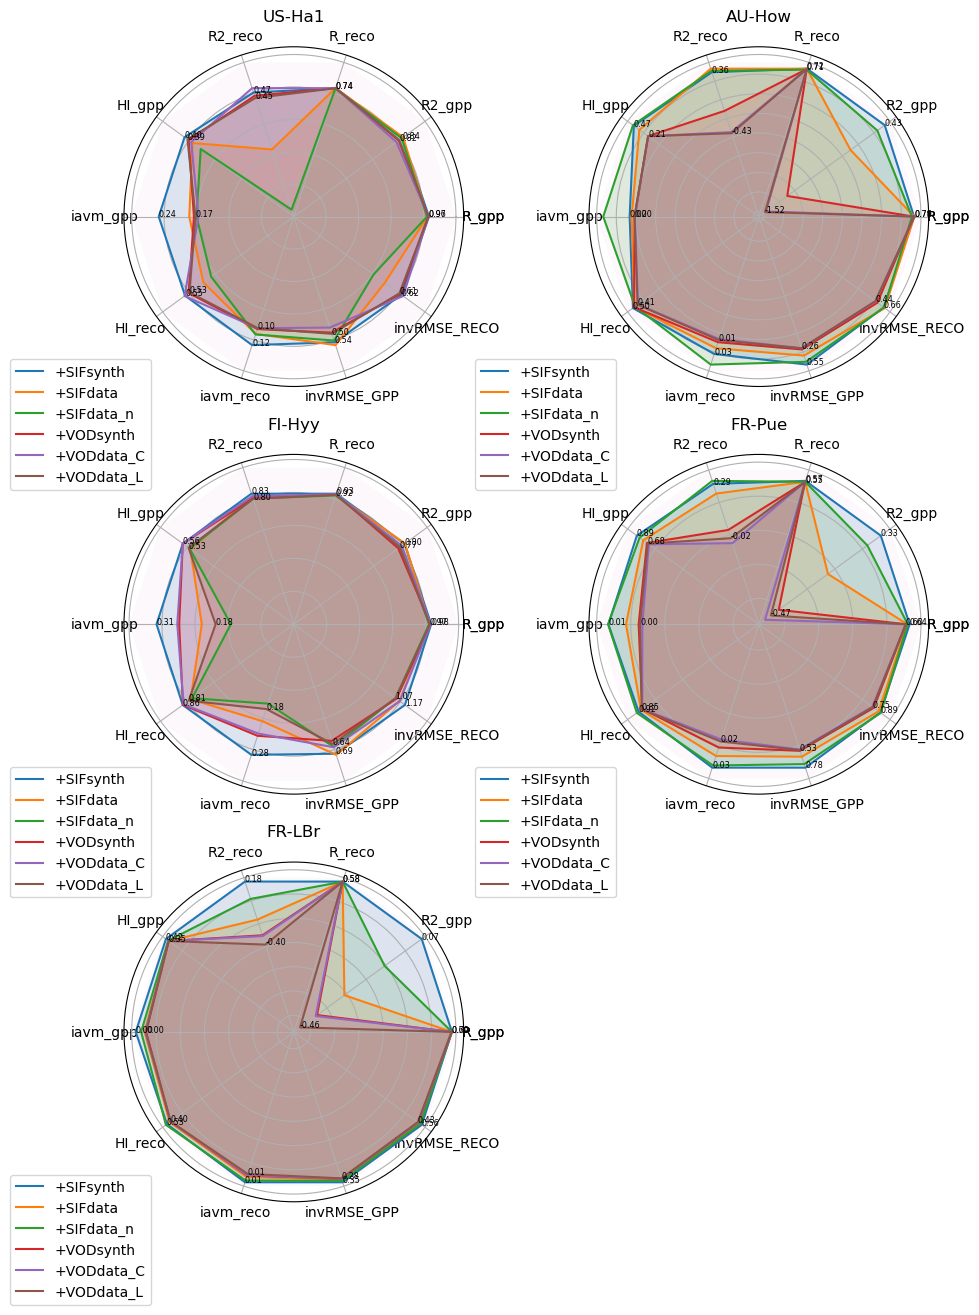

In [26]:
def spider2(df, *, id_column, title=None, max_values=None, padding=1.25):
    categories = df._get_numeric_data().columns.tolist()
    data = df[categories].to_dict(orient='list')
    ids = df[id_column].tolist()
    if max_values is None:
        max_values = {key: padding*max(value) for key, value in data.items()}
        
    normalized_data = {key: np.array(value) / max_values[key] for key, value in data.items()}
    num_vars = len(data.keys())
    tiks = list(data.keys())
    tiks += tiks[:1]
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist() + [0]
    #fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))
    for i, model_name in enumerate(ids):
        values = [normalized_data[key][i] for key in data.keys()]
        actual_values = [data[key][i] for key in data.keys()]
        values += values[:1]  # Close the plot for a better look
        ax.plot(angles, values, label=model_name)
        ax.fill(angles, values, alpha=0.15)
        
        if (i==0) or (i==len(ids)-1):

            for _x, _y, t in zip(angles, values, actual_values):
                t = f'{t:.2f}' if isinstance(t, float) else str(t)
                ax.text(_x, _y, t, size='xx-small')
            
    ax.fill(angles, np.ones(num_vars + 1), alpha=0.05)
    ax.set_yticklabels([])
    ax.set_xticks(angles)
    ax.set_xticklabels(tiks)
    ax.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
    if title is not None: plt.title(title)
    #plt.show()
    plt.savefig('sif_or_vod.png', bbox_inches='tight', dpi = 400)
radar = spider2    
sites = [ 'US-Ha1', 'AU-How',  'FI-Hyy','FR-Pue', 'FR-LBr']
fig = plt.figure(figsize=(11, 15))
for i, site in enumerate(sites):
    data1 = site + '_revision_all_dt.csv'
    data = pd.read_csv(data1)
    data['invRMSE_GPP'] = 1/data['RMSE_gpp']
    data['invRMSE_RECO'] = 1/data['RMSE_reco']
    data = data.drop(['RMSE_reco', 'RMSE_gpp'], axis=1)
    
    df = data.drop(columns=['case'])
    col_names = df.columns
    #for cl in col_names:
     #   data[cl] = (data[cl]-np.mean(data[cl]))/np.std(data[cl])

    data_group = data.groupby('case').mean().reset_index()
    
    data_group = data_group[data_group['case'].isin([ 'SIF_synth06', 'SIF_data06', 'SIF_data_n','VOD_synth02', 'VOD_data02',  'VOD_Xdata02'])]
    data_group.loc[data_group['case'] == "SIF_synth06", "case"] = '+SIFsynth'
    data_group.loc[data_group['case'] == "SIF_data06", "case"] = '+SIFdata'
    data_group.loc[data_group['case'] == "SIF_data_n", "case"] = '+SIFdata_n'
    data_group.loc[data_group['case'] == "VOD_synth02", "case"] = '+VODsynth'
    data_group.loc[data_group['case'] == "VOD_data02", "case"] = '+VODdata_L'
    data_group.loc[data_group['case'] == "VOD_Xdata02", "case"] = '+VODdata_C'
    custom_order = [ '+SIFsynth', '+SIFdata', '+SIFdata_n','+VODsynth', '+VODdata_C', '+VODdata_L']

# Convert 'case' column to categorical with the specified order
    data_group['case'] = pd.Categorical(data_group['case'], categories=custom_order, ordered=True)


    data_group = data_group.sort_values(by='case')

    ax = fig.add_subplot(3, 2, i+1, polar=True)
#print(data)
    spider2(
        data_group,
        id_column='case',
        title=site,
        padding=1.2
        )


In [28]:
data1 = 'US-Ha1' + '_revision_all_dt.csv'
data = pd.read_csv(data1)


data_group = data.groupby('case').std().reset_index()
data_group

,case,R_gpp,RMSE_gpp,R2_gpp,R_reco,RMSE_reco,R2_reco,HI_gpp,iavm_gpp,HI_reco,iavm_reco
0,811_exp_uncopt,0.000283,0.049188,0.006636,0.000778,0.054820,0.041734,0.008148,0.046689,0.002773,0.010424
1,811_pure,0.000072,0.012883,0.001955,0.000133,0.012324,0.010403,0.002448,0.003229,0.000000,0.000951
2,SIF+VOD,0.000159,0.035567,0.006482,0.000253,0.013396,0.008707,0.006985,0.006024,0.001065,0.005111
3,SIF07+VOD02,0.000161,0.029673,0.005330,0.000350,0.017739,0.011719,0.004106,0.003526,0.001375,0.004673
4,SIF14+VOD04,0.000257,0.033316,0.005814,0.000227,0.020960,0.014639,0.001590,0.005671,0.008784,0.003291
5,SIF24+VOD08,0.000512,0.057894,0.010148,0.000212,0.045110,0.031614,0.003859,0.007450,0.016037,0.003732
6,SIF_data04,0.000608,0.014045,0.002350,0.000520,0.051330,0.045303,0.001185,0.004111,0.013262,0.002139
7,SIF_data06,0.000618,0.039947,0.006601,0.000409,0.065715,0.052011,0.015215,0.009315,0.008159,0.004939
8,SIF_data08,0.000464,0.033996,0.005624,0.000615,0.032693,0.025288,0.010614,0.009006,0.009705,0.005302
9,SIF_data1,0.000561,0.050345,0.008356,0.000302,0.078446,0.059551,0.006470,0.007432,0.017395,0.005799


In [36]:
data.columns


Index(['x', 'R_GPP', 'R2_GPP', 'RMSE_GPP', 'HI_GPP', 'IAMR_GPP', 'R_RECO',
       'R2_RECO', 'RMSE_RECO', 'HI_RECO', 'IAMR_RECO'],
      dtype='object')

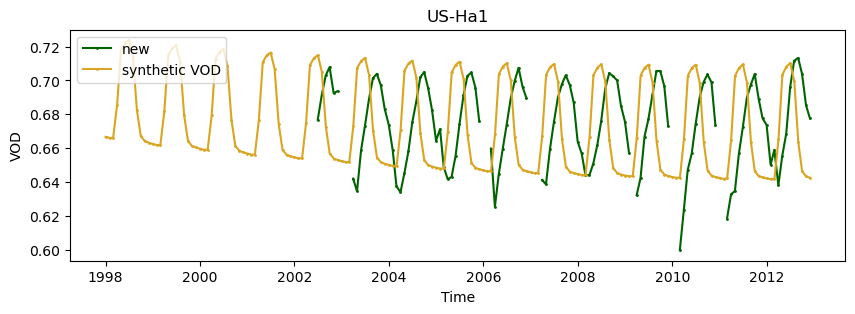

In [48]:
#vod0 = pd.read_pickle('vod_fi_hyy3.pkl')
#vod0['date'] = pd.to_datetime(vod0['date'])

fig = plt.figure(figsize=(10, 3))

wood = np.median(CBR_new['POOLS'][:,:,poolnames.index('Wood C')],axis=0)
leaves = np.median(CBR_new['POOLS'][:,:,poolnames.index('Foliar C')],axis=0)
    
    
#synth = 0.000015*wood+ 0.00025*leaves +0.42#- correct coef for us ha1 based on NBE LAI AB -0
synth = 0.000015*wood+ 0.0004*leaves +0.42#- correct coef for us ha1 based on ECD -2


#synth = 0.00005*wood+ 0.002*leaves #- correct coef for fr pue based on NBE LAI AB -0

#wood_m = np.mean(wood)
#leaves_m = np.mean(leaves)




#plt.plot(vod0['date'], vod0['vod'], marker = 'o', color = 'darkred', ms = 1, label = 'VODCA data 2')
#plt.plot(vod['date'], vod['str_mean'], marker = 'o', color = 'darkgreen', ms = 1, label = 'new')


#plt.plot(vod['TIMESTAMP'], synth, marker = 'o', color = 'goldenrod', ms = 1, label = 'synthetic VOD')

#plt.plot(vod['TIMESTAMP'], synth3, marker = 'o', color = 'navy', ms = 1, label = 'new synthetic VOD')



plt.title(basename)
plt.xlabel('Time')
plt.ylabel('VOD')
plt.legend(loc = 'upper left')
plt.show()

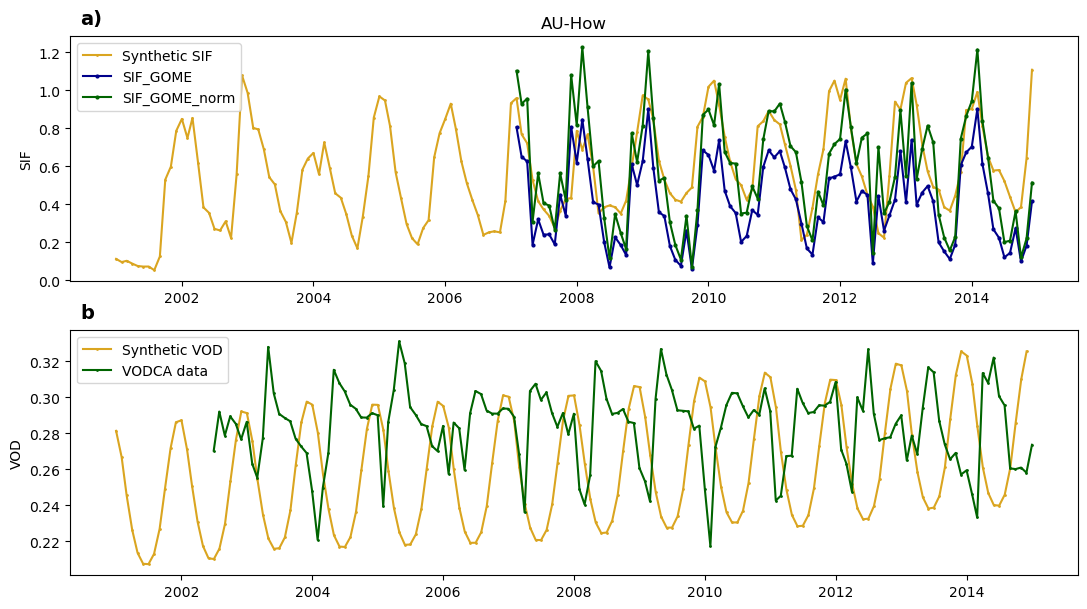

In [147]:
fig = plt.figure(figsize=(13, 7))

ax = fig.add_subplot(2, 1, 1)

plt.plot(flux_data['TIMESTAMP'], sif, marker = 'o', color = 'goldenrod', ms = 1, label = 'Synthetic SIF')
plt.plot(flux_cl['TIMESTAMP'], flux_cl['SIF_GOME'], marker = 'o', color = 'darkblue', ms = 2, label = 'SIF_GOME')
plt.plot(flux_cl['TIMESTAMP'], flux_cl['SIF_GOME_NORM'], marker = 'o', color = 'darkgreen', ms = 2, label = 'SIF_GOME_norm')
plt.legend()
plt.title(basename)

#plt.ylabel('GPP, gC m-2 d-1')
plt.ylabel('SIF')

ax.text(0.01, 1.05, 'a)', transform=ax.transAxes, size=14, weight='bold')

ax = fig.add_subplot(2, 1, 2)


plt.plot(vod['TIMESTAMP'], synth, marker = 'o', color = 'goldenrod', ms = 1, label = 'Synthetic VOD')
plt.plot(vod['date'], vod['vod'], marker = 'o', color = 'darkgreen', ms = 1, label = 'VODCA data')

plt.legend()
plt.ylabel('VOD')
ax.text(0.01, 1.05, 'b', transform=ax.transAxes, size=14, weight='bold')

plt.savefig('AU_sif.pdf', bbox_inches='tight')

plt.show()

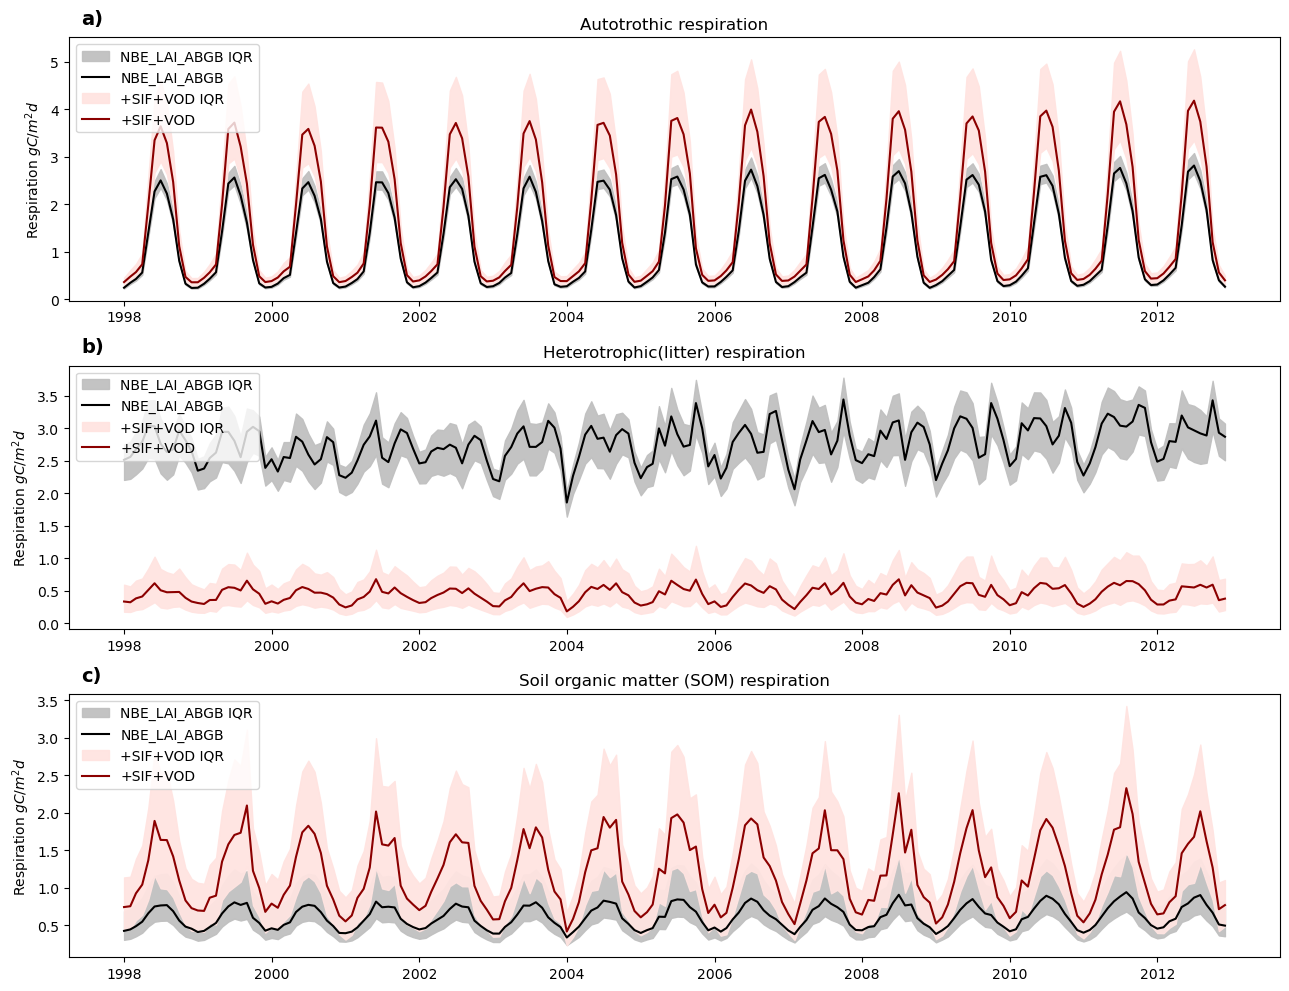

In [30]:
fig = plt.figure(figsize=(13, 10))

ax = fig.add_subplot(3, 1, 1)

ax.fill_between(flux_data['TIMESTAMP'], resa_252, resa_752, color = 'silver', alpha = 0.95, label = 'NBE_LAI_ABGB IQR')
plt.plot(flux_data['TIMESTAMP'], np.median(data_a2,axis=0),linewidth=1.5,color='black',label='NBE_LAI_ABGB')
ax.fill_between(flux_data['TIMESTAMP'], resa_25, resa_75, color = 'mistyrose', alpha = 0.95, label = '+SIF+VOD IQR')
plt.plot(flux_data['TIMESTAMP'], np.median(data_a,axis=0),linewidth=1.5,color='darkred',label='+SIF+VOD')

#plt.plot(flux_data['TIMESTAMP'], flux_data['RECO_NT_VUT_REF'], color='royalblue', linewidth=1, marker = '.', label='NT Reco')
#ax.fill_between(flux_data['TIMESTAMP'], flux_data['RECO_NT_VUT_25'], flux_data['RECO_NT_VUT_75'], color = 'cornflowerblue', alpha = 0.5, label = 'NT Reco IQR')

#plt.plot(flux_data['TIMESTAMP'], flux_data['RECO_DT_VUT_REF'], color='darkgoldenrod', linewidth=1, marker = '.', label='DT Reco')

#ax.fill_between(flux_data['TIMESTAMP'], flux_data['RECO_DT_VUT_25'], flux_data['RECO_DT_VUT_75'], color = 'burlywood', alpha = 0.5, label = 'DT Reco IQR')

plt.title('Autotrothic respiration')

#plt.ylim([0,20])
ax.set_ylabel('Respiration $gC/m^2d$')
#ax.set_xlabel('Time [months]')
myFmt = DateFormatter("%Y")
ax.xaxis.set_major_formatter(myFmt)

plt.legend(loc = 'upper left')

ax.text(0.01, 1.05, 'a)', transform=ax.transAxes, size=14, weight='bold')

ax = fig.add_subplot(3, 1, 2)


ax.fill_between(flux_data['TIMESTAMP'], resh_252, resh_752, color = 'silver', alpha = 0.95, label = 'NBE_LAI_ABGB IQR')
plt.plot(flux_data['TIMESTAMP'], np.median(data_h2,axis=0),linewidth=1.5,color='black',label='NBE_LAI_ABGB')
ax.fill_between(flux_data['TIMESTAMP'], resh_25, resh_75, color = 'mistyrose', alpha = 0.95, label = '+SIF+VOD IQR')
plt.plot(flux_data['TIMESTAMP'], np.median(data_h,axis=0),linewidth=1.5,color='darkred',label='+SIF+VOD')


plt.title('Heterotrophic(litter) respiration')

#plt.ylim([0,20])
ax.set_ylabel('Respiration $gC/m^2d$')
#ax.set_xlabel('Time [months]')
myFmt = DateFormatter("%Y")
ax.xaxis.set_major_formatter(myFmt)

plt.legend(loc = 'upper left')
ax.text(0.01, 1.05, 'b)', transform=ax.transAxes, size=14, weight='bold')



ax = fig.add_subplot(3, 1, 3)


ax.fill_between(flux_data['TIMESTAMP'], ress_252, ress_752, color = 'silver', alpha = 0.95, label = 'NBE_LAI_ABGB IQR')
plt.plot(flux_data['TIMESTAMP'], np.median(data_s2,axis=0),linewidth=1.5,color='black',label='NBE_LAI_ABGB')
ax.fill_between(flux_data['TIMESTAMP'], ress_25, ress_75, color = 'mistyrose', alpha = 0.95, label = '+SIF+VOD IQR')
plt.plot(flux_data['TIMESTAMP'], np.median(data_s,axis=0),linewidth=1.5,color='darkred',label='+SIF+VOD')


plt.title('Soil organic matter (SOM) respiration')

#plt.ylim([0,20])
ax.set_ylabel('Respiration $gC/m^2d$')
#ax.set_xlabel('Time [months]')
myFmt = DateFormatter("%Y")
ax.xaxis.set_major_formatter(myFmt)

plt.legend(loc = 'upper left')
ax.text(0.01, 1.05, 'c)', transform=ax.transAxes, size=14, weight='bold')


fig.tight_layout()
plt.savefig('HA_partit.pdf', bbox_inches='tight')


plt.show()




In [11]:
new_cbf2 = dir_cbf + basename +'new_data.cbf'
new_cbr2 = dir_cbr + basename + '811_exp_uncopt-6.cbr'
chain = 0

CBR_old = pC.forward_run(dircardamom, dir_output, dir_cbr, new_cbf2, new_cbr2, chain )

OKCHECK:CHECK: DATA structure successfully initialized
about to declare EDCD
DALECmodel.EDCD = 0x0
EDCD->EQF = 2.00
done with declaration
DALECmodel.EDCD->EQF = 2.00
DATA->nodays = 180
DATA->nofluxes = 30
nee annual unc = -9999.000000
nee obs unc = 1.000000
lai other prior = -9999.000000
lai other unc = 0.568798
reading file...
No prescribed met reference means, calculating based on driver data
frf = 0
***CBF FILE SUMMARY***MODEL ID = 811
No days = 180
Mean Rad = 13.245573
Mean Temp = 8.297143
Mean Prec = 3.241389
Latitude = 43.000000
Number of MET drivers9
Number of GPP obs. = 0
Number of LAI obs. = 151
Number of NEE obs. = 156
Number of EWT obs. = 0
Number of CH4 obs. = 0
Number of SIF obs. = 0
Number of VOD obs. = 0
Number of obs. = 13
Ecological & Dynamic Constraints options
EDC likelihood option = 1
EDC diagnostics option = 0
*****END OF CBF FILE SUMMARY***number of parvecs to run = 10000
The exit code was: 0


In [12]:
new_cbf = dir_cbf + basename +'SIF+VOD.cbf'
new_cbr = dir_cbr + basename + 'SIF+VOD-0.cbr'
chain = 0

CBR_new2 = pC.forward_run(dircardamom, dir_output, dir_cbr, new_cbf, new_cbr, chain )

OKCHECK:CHECK: DATA structure successfully initialized
about to declare EDCD
DALECmodel.EDCD = 0x0
EDCD->EQF = 2.00
done with declaration
DALECmodel.EDCD->EQF = 2.00
DATA->nodays = 180
DATA->nofluxes = 30
nee annual unc = -9999.000000
nee obs unc = 1.000000
lai other prior = -9999.000000
lai other unc = 0.568798
reading file...
No prescribed met reference means, calculating based on driver data
frf = 0
***CBF FILE SUMMARY***MODEL ID = 895
No days = 180
Mean Rad = 13.245573
Mean Temp = 8.297143
Mean Prec = 3.241389
Latitude = 43.000000
Number of MET drivers9
Number of GPP obs. = 0
Number of LAI obs. = 151
Number of NEE obs. = 0
Number of EWT obs. = 0
Number of CH4 obs. = 0
Number of SIF obs. = 180
Number of VOD obs. = 113
Number of obs. = 13
Ecological & Dynamic Constraints options
EDC likelihood option = 1
EDC diagnostics option = 0
*****END OF CBF FILE SUMMARY***number of parvecs to run = 10000
The exit code was: 0


In [13]:
data_ao = CBR_old['FLUXES'][:,:,fluxnames.index('respiration_auto (GPP -> autotrophic respiration)')]
data_ho = CBR_old['FLUXES'][:,:,fluxnames.index('respiration_het_litter (litter respiration)')]
data_so = CBR_old['FLUXES'][:,:,fluxnames.index('respiration_het_som (SOM respiration)')]
full_reso = data_ao + data_ho + data_so


data_a2 = CBR_new2['FLUXES'][:,:,fluxnames.index('respiration_auto (GPP -> autotrophic respiration)')]
data_h2 = CBR_new2['FLUXES'][:,:,fluxnames.index('respiration_het_litter (litter respiration)')]
data_s2 = CBR_new2['FLUXES'][:,:,fluxnames.index('respiration_het_som (SOM respiration)')]
full_res2 = data_a2 + data_h2 + data_s2 

data_PLUS = CBR_new2['FLUXES'][:,:,fluxnames.index('GPP')]
data_PLUSo = CBR_old['FLUXES'][:,:,fluxnames.index('GPP')]

In [14]:
lower = 0.25
upper = 0.75
gpp_25 = np.quantile(data_PLUS, lower, axis=0)
gpp_75 = np.quantile(data_PLUS, upper, axis=0)
res_25 = np.quantile(full_res2, lower, axis=0)
res_75 = np.quantile(full_res2, upper, axis=0)

gpp_25o = np.quantile(data_PLUSo, lower, axis=0)
gpp_75o = np.quantile(data_PLUSo, upper, axis=0)
res_25o = np.quantile(full_reso, lower, axis=0)
res_75o = np.quantile(full_reso, upper, axis=0)

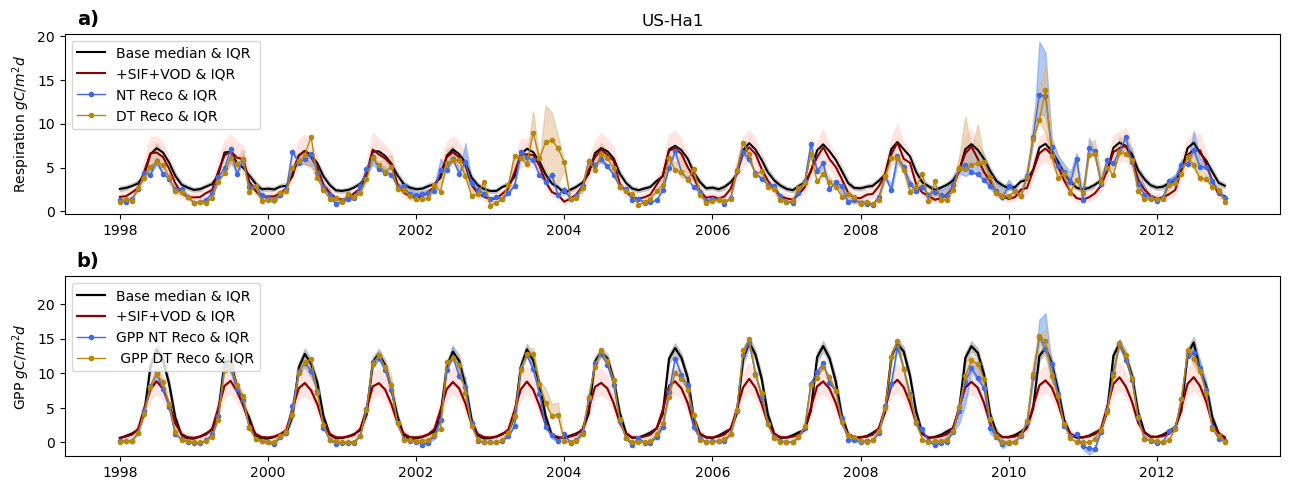

In [15]:
fig = plt.figure(figsize=(13, 5))

ax = fig.add_subplot(2, 1, 1)

ax.fill_between(flux_data['TIMESTAMP'], res_25o, res_75o, color = 'silver', alpha = 0.95, label = '__nolabel__')
plt.plot(flux_data['TIMESTAMP'], np.median(full_reso,axis=0),linewidth=1.5,color='black',label='Base median & IQR ')
ax.fill_between(flux_data['TIMESTAMP'], res_25, res_75, color = 'mistyrose', alpha = 0.95, label = '__nolabel__')
plt.plot(flux_data['TIMESTAMP'], np.median(full_res2,axis=0),linewidth=1.5,color='darkred',label='+SIF+VOD & IQR')
#plt.plot(flux_data['TIMESTAMP'], np.median(full_res6,axis=0),linewidth=1.5,color='darkgreen',label='edc6')

plt.plot(flux_data['TIMESTAMP'], flux_data['RECO_NT_VUT_REF'], color='royalblue', linewidth=1, marker = '.', label='NT Reco & IQR')
ax.fill_between(flux_data['TIMESTAMP'], flux_data['RECO_NT_VUT_25'], flux_data['RECO_NT_VUT_75'], color = 'cornflowerblue', alpha = 0.5, label = '__nolabel__')

plt.plot(flux_data['TIMESTAMP'], flux_data['RECO_DT_VUT_REF'], color='darkgoldenrod', linewidth=1, marker = '.', label='DT Reco & IQR')

ax.fill_between(flux_data['TIMESTAMP'], flux_data['RECO_DT_VUT_25'], flux_data['RECO_DT_VUT_75'], color = 'burlywood', alpha = 0.5, label = '__nolabel__')

plt.title(basename)

#plt.ylim([0,20])
ax.set_ylabel('Respiration $gC/m^2d$')
#ax.set_xlabel('Time [months]')
myFmt = DateFormatter("%Y")
ax.xaxis.set_major_formatter(myFmt)

plt.legend(loc = 'upper left')

ax.text(0.01, 1.05, 'a)', transform=ax.transAxes, size=14, weight='bold')

ax = fig.add_subplot(2, 1, 2)
ax.fill_between(flux_data['TIMESTAMP'], gpp_25o, gpp_75o, color = 'silver', alpha = 0.95, label = '__nolabel__')
plt.plot(flux_data['TIMESTAMP'], np.median(data_PLUSo,axis=0),linewidth=1.6,color='black',label='Base median & IQR')
ax.fill_between(flux_data['TIMESTAMP'], gpp_25, gpp_75, color = 'mistyrose', alpha = 0.95, label = '__nolabel__')

plt.plot(flux_data['TIMESTAMP'], np.median(data_PLUS,axis=0),linewidth=1.6,color='darkred',label='+SIF+VOD & IQR')
#plt.plot(flux_data['TIMESTAMP'], np.median(data_PLUS6,axis=0),linewidth=1.5,color='darkgreen',label='edc6')


plt.plot(flux_data['TIMESTAMP'], flux_data['GPP_NT_VUT_REF'], color='royalblue', linewidth=1, marker = '.', label='GPP NT Reco & IQR')
ax.fill_between(flux_data['TIMESTAMP'], flux_data['GPP_NT_VUT_25'], flux_data['GPP_NT_VUT_75'], color = 'cornflowerblue', alpha = 0.5, label = '__nolabel__')

plt.plot(flux_data['TIMESTAMP'], flux_data['GPP_DT_VUT_REF'], color='darkgoldenrod', linewidth=1, marker = '.', label=' GPP DT Reco & IQR')

ax.fill_between(flux_data['TIMESTAMP'], flux_data['GPP_DT_VUT_25'], flux_data['GPP_DT_VUT_75'], color = 'burlywood', alpha = 0.5, label = '__nolabel__')


ax.set_ylim([-2,24])


ax.set_ylabel('GPP $gC/m^2d$')
#ax.set_xlabel('Time [months]')
myFmt = DateFormatter("%Y")
ax.xaxis.set_major_formatter(myFmt)

plt.legend(loc = 'upper left')
ax.text(0.01, 1.05, 'b)', transform=ax.transAxes, size=14, weight='bold')


fig.tight_layout()
#plt.savefig(basename + '_ts.pdf', bbox_inches='tight')


plt.show()




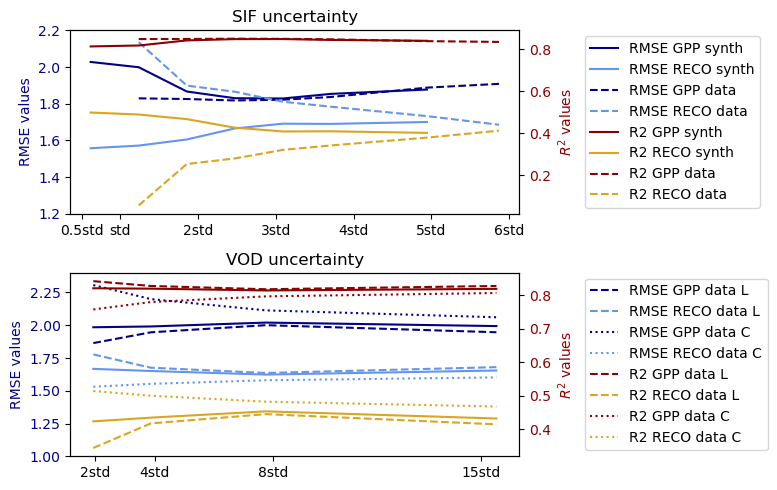

In [16]:
#sites = [ 'US-Ha1', 'AU-How', 'FI-Hyy','FR-Pue', 'FR-LBr']
site = 'US-Ha1'
X = [0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.6, 1.9]
XX = [0.05, 0.1, 0.2, 0.4]
data1 = site + '_revision_all_dt.csv'
data = pd.read_csv(data1)
    
data_group = data.groupby('case').mean().reset_index()
    
data_group1 = data_group[data_group['case'].isin(['SIF_synth02', 'SIF_synth04', 'SIF_synth06', 'SIF_synth08',
                                                 'SIF_synth1', 'SIF_synth12', 'SIF_synth16'])]
data_group2 = data_group[data_group['case'].isin([ 'SIF_data04', 'SIF_data06', 'SIF_data08',
                                                 'SIF_data1', 'SIF_data12', 'SIF_data16', 'SIF_data19'])]
data_group3 = data_group[data_group['case'].isin(['VOD_Xdata005', 'VOD_Xdata01', 'VOD_Xdata02', 'VOD_Xdata04'])]

data_group4 = data_group[data_group['case'].isin(['VOD_data005', 'VOD_data01', 'VOD_data02', 'VOD_data04',])]

data_group5 = data_group[data_group['case'].isin([ 'VOD_synth005', 'VOD_synth01', 'VOD_synth02', 'VOD_synth04'])]

fig = plt.figure(figsize=(10, 5))

ax = fig.add_subplot(2, 1, 1)

ax.set_ylabel('RMSE values', color='darkblue')


ax.plot(X[:-1], data_group1['RMSE_gpp'], color = 'darkblue', label = 'RMSE GPP synth')
ax.plot(X[:-1], data_group1['RMSE_reco'], color = 'cornflowerblue', label = 'RMSE RECO synth')
ax.plot(X[1:], data_group2['RMSE_gpp'], color = 'darkblue', label = 'RMSE GPP data', linestyle = 'dashed')
ax.plot(X[1:], data_group2['RMSE_reco'], color = 'cornflowerblue', label = 'RMSE RECO data',  linestyle = 'dashed')

ax.tick_params(axis='y', labelcolor='darkblue')
ax.set_xticks([0.1618, 0.3236, 2*0.3236 , 3*0.3236, 4*0.3236, 5*0.3236, 6*0.3236])
ax.set_xticklabels(['0.5std', 'std', '2std', '3std', '4std', '5std', '6std' ])

# Instantiate a second axes that shares the same x-axis
ax2 = ax.twinx()  
ax2.set_ylabel('$R^2$ values', color='darkred')
ax2.set_xlabel('Uncertainty')

ax2.plot(X[:-1], data_group1['R2_gpp'], color = 'darkred', label = 'R2 GPP synth')
ax2.plot(X[:-1], data_group1['R2_reco'], color = 'goldenrod', label = 'R2 RECO synth')
ax2.plot(X[1:], data_group2['R2_gpp'], color = 'darkred', label = 'R2 GPP data', linestyle = 'dashed')
ax2.plot(X[1:], data_group2['R2_reco'], color = 'goldenrod', label = 'R2 RECO data', linestyle = 'dashed')

ax2.tick_params(axis='y', labelcolor='darkred')
ax.set_ylim([1.2, 2.2])
plt.title('SIF uncertainty')
lines_1, labels_1 = ax.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax.legend(lines_1 + lines_2, labels_1 + labels_2, loc='center left', bbox_to_anchor=(1.13, 0.5))


ax3 = fig.add_subplot(2, 1, 2)

ax3.set_ylabel('RMSE values', color='darkblue')
ax3.set_ylim([1, 2.4])
ax3.set_xlim([0, 0.5])

ax3.plot(XX, data_group5['RMSE_gpp'], color = 'darkblue', label = '__nolabel__')
ax3.plot(XX, data_group5['RMSE_reco'], color = 'cornflowerblue', label = '__nolabel__')
ax3.plot(XX, data_group4['RMSE_gpp'], color = 'darkblue', label = 'RMSE GPP data L', linestyle = 'dashed')
ax3.plot(XX, data_group4['RMSE_reco'], color = 'cornflowerblue', label = 'RMSE RECO data L',  linestyle = 'dashed')
ax3.plot(XX, data_group3['RMSE_gpp'], color = 'darkblue', label = 'RMSE GPP data C', linestyle = 'dotted')
ax3.plot(XX, data_group3['RMSE_reco'], color = 'cornflowerblue', label = 'RMSE RECO data C',  linestyle = 'dotted')

ax3.tick_params(axis='y', labelcolor='darkblue')

# Instantiate a second axes that shares the same x-axis
ax4 = ax3.twinx()  
ax4.set_ylabel('$R^2$ values', color='darkred')
ax4.set_xlabel('Uncertainty')

ax4.plot(XX, data_group5['R2_gpp'], color = 'darkred', label = '__nolabel__')
ax4.plot(XX, data_group5['R2_reco'], color = 'goldenrod', label = '__nolabel__')
ax4.plot(XX, data_group4['R2_gpp'], color = 'darkred', label = 'R2 GPP data L', linestyle = 'dashed')
ax4.plot(XX, data_group4['R2_reco'], color = 'goldenrod', label = 'R2 RECO data L', linestyle = 'dashed')
ax4.plot(XX, data_group3['R2_gpp'], color = 'darkred', label = 'R2 GPP data C', linestyle = 'dotted')
ax4.plot(XX, data_group3['R2_reco'], color = 'goldenrod', label = 'R2 RECO data C', linestyle = 'dotted')


ax4.tick_params(axis='y', labelcolor='darkred')
ax3.set_xlim([0.03, 0.42])
ax3.set_xticks([0.0516, 0.1032, 0.2064, 0.387])
ax3.set_xticklabels([ '2std', '4std', '8std', '15std' ])

plt.title('VOD uncertainty')

# Combine legends
lines_3, labels_3 = ax3.get_legend_handles_labels()
lines_4, labels_4 = ax4.get_legend_handles_labels()
ax3.legend(lines_3 + lines_4, labels_3 + labels_4, loc='center left', bbox_to_anchor=(1.13, 0.5))

plt.tight_layout(rect=[0, 0, 0.83, 1])

#plt.savefig('uncertainty.png', bbox_inches='tight', dpi = 300)
plt.show()

In [17]:
sites = [ 'US-Ha1', 'AU-How', 'FI-Hyy']

for i, site in enumerate(sites):
    data1 = site + '_revision_all_dt.csv'
    data = pd.read_csv(data1)
    
    data_group = data.groupby('case').mean().reset_index()
    
    data_group = data_group[data_group['case'].isin(['none'])]
    print(site)
    print(data_group)
    data_group2 = data.groupby('case').std().reset_index()
    print('STD')
    data_group2 = data_group2[data_group2['case'].isin(['none'])]
    print(data_group2)
    

US-Ha1
    case     R_gpp  RMSE_gpp    R2_gpp    R_reco  RMSE_reco   R2_reco  \
38  none  0.844574  5.910039 -0.592956  0.716873   3.580716 -1.662672   

      HI_gpp  iavm_gpp   HI_reco  iavm_reco  
38  0.252572   0.00027  0.183882   0.001011  
STD
    case     R_gpp  RMSE_gpp    R2_gpp    R_reco  RMSE_reco   R2_reco  HI_gpp  \
38  none  0.021983  0.177378  0.094742  0.003186   0.194131  0.283932     0.0   

    iavm_gpp   HI_reco  iavm_reco  
38  0.000113  0.009236    0.00062  
AU-How
    case     R_gpp  RMSE_gpp    R2_gpp    R_reco  RMSE_reco   R2_reco  \
13  none  0.689527  5.540642 -4.329242  0.707543   3.907597 -3.304906   

      HI_gpp  iavm_gpp   HI_reco  iavm_reco  
13  0.025089  0.000118  0.049358   0.000148  
STD
    case     R_gpp  RMSE_gpp    R2_gpp    R_reco  RMSE_reco   R2_reco  \
13  none  0.013836  0.043186  0.083035  0.003934   0.047531  0.104619   

      HI_gpp  iavm_gpp   HI_reco  iavm_reco  
13  0.002585  0.000046  0.010472   0.000056  
FI-Hyy
    case     R_gpp 

In [46]:
#cbf_load = rwbin.read_cbf_file(new_cbf)
modelid = int(895)
parameter_names = readcardamommodel.get_parnames(modelid,output='shortnames')

INFO = {'nopars':33, 'latterhalf':0}
INFO2 = {'nopars':36, 'latterhalf':0}


#cbr_load = rwbin.read_cbr_file(cardamom_cbr,INFO = INFO)
i = [1, 9, 10,  16, 21, 18, 19, 20,  22, 17]
#i = [1, 10,  16, 18, 19, 20]


list_n = [parameter_names[x] for x in i]


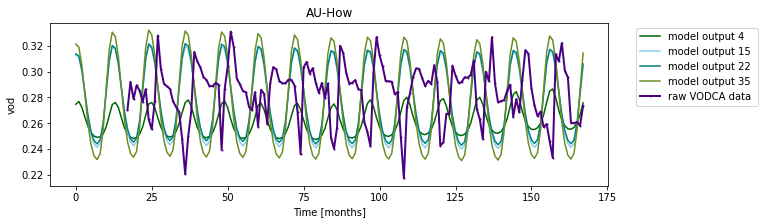

In [49]:


wood = np.median(CBR_new['POOLS'][:,:,poolnames.index('Wood C')],axis=0)
leaves = np.median(CBR_new['POOLS'][:,:,poolnames.index('Foliar C')],axis=0)

vod_model = p[1]*wood + p[2]*leaves
fig = plt.figure(figsize=(10, 3))

plt.plot(model_4, color ='darkgreen', label = 'model output 4')
plt.plot(vod_model, color ='skyblue', label = 'model output 15')
plt.plot(model_22, color ='teal', label = 'model output 22')
plt.plot(model_35, color ='olivedrab', label = 'model output 35')




#plt.plot(vod2, label = 'model w/ L only')

x = np.arange(17, 168, 1)


plt.plot(x, vod['vod'], marker = 'o', ms = 1, linewidth = 2, color ='indigo', label = 'raw VODCA data ')
plt.ylabel('vod')
plt.xlabel('Time [months]')
plt.legend()
plt.title("AU-How")

plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")


plt.show()

In [47]:
def parameter_hist_compare(list_n, cbr_load, cbr_load2, name_ind, labels, base, outer_grid, nnn, true_param = None):
    param = ['Frac GPP resp', 'Q10', 'Canopy eff', 'LMCA', 'Moisture factor', 'C labile', 'C foliar', 'C root', 'C wood' , 'C SOM']
    n = len(list_n)
    if n%5 ==0:
        a = n//5
    else:
        a= n//5+1
#    fig = plt.figure(figsize=(11, 4))




    inner_grid = outer_grid[nnn, 0].subgridspec(2, 5, wspace=0, hspace=0)
    axs = inner_grid.subplots()  # Create all subplots for the inner grid.


    for ind, parname in enumerate(name_ind):
        #print(parname)
        ax = axs[ind]
        index = name_ind[ind]
        #heights, bins = np.histogram(cbr_load[:,index], bins=10, density = True)
        #vm = np.max(heights)
       # ranges.iloc[:,ind]
        #print(index)
        #print(cbr_load[:,index])
        if ind < 10:
            plt.hist(cbr_load[:,index], bins=ranges.iloc[:,ind], density = True, alpha = 0.7, edgecolor='navy', linewidth=0.6,  label = labels[0])
            plt.hist(cbr_load2[:,index], bins=ranges.iloc[:,ind], density = True, alpha = 0.7, edgecolor='brown', linewidth=0.6,  label = labels[1])
        else:
            plt.hist(cbr_load2[:,index], bins=ranges.iloc[:,ind], density = True, alpha = 0.7, edgecolor='brown', linewidth=0.6,  label = labels[1])

        plt.title(param[ind])
        plt.yticks([]) 
        if ind ==0 or ind == 5:
            plt.ylabel('Probability density')
    ax.legend(bbox_to_anchor=(1.05, 0), loc='lower left', borderaxespad=0.)
     
    plt.suptitle(base)    
#    fig.tight_layout()
 #   plt.savefig('FRPue_param_v1.pdf', bbox_inches='tight')


In [11]:
ranges = pd.DataFrame({'r1' : np.arange(0.2, 0.8, 0.06), 'r2' : np.arange(0.018, 0.081, (0.08-0.018)/10), 
                      'r3': np.arange(5, 50.1, 4.5), 'r4': np.arange(5, 200.1, 19.5), 'r9': np.arange(0.01, 0.51, 0.0499 ),
                       'r5': np.arange(1, 500.1, 49.9 ),
                      'r6': np.arange(1, 200.1, 19.9 ), 'r7': np.arange(1, 1000.1, 99.9 ), 
                       #'r8': np.arange(2000, 7000.1, 454.6 ),
                       'r8': np.arange(2000, 10000.1, 727.3 ),
                       'r10': np.arange(1, 50000.1, 4999.9 )})

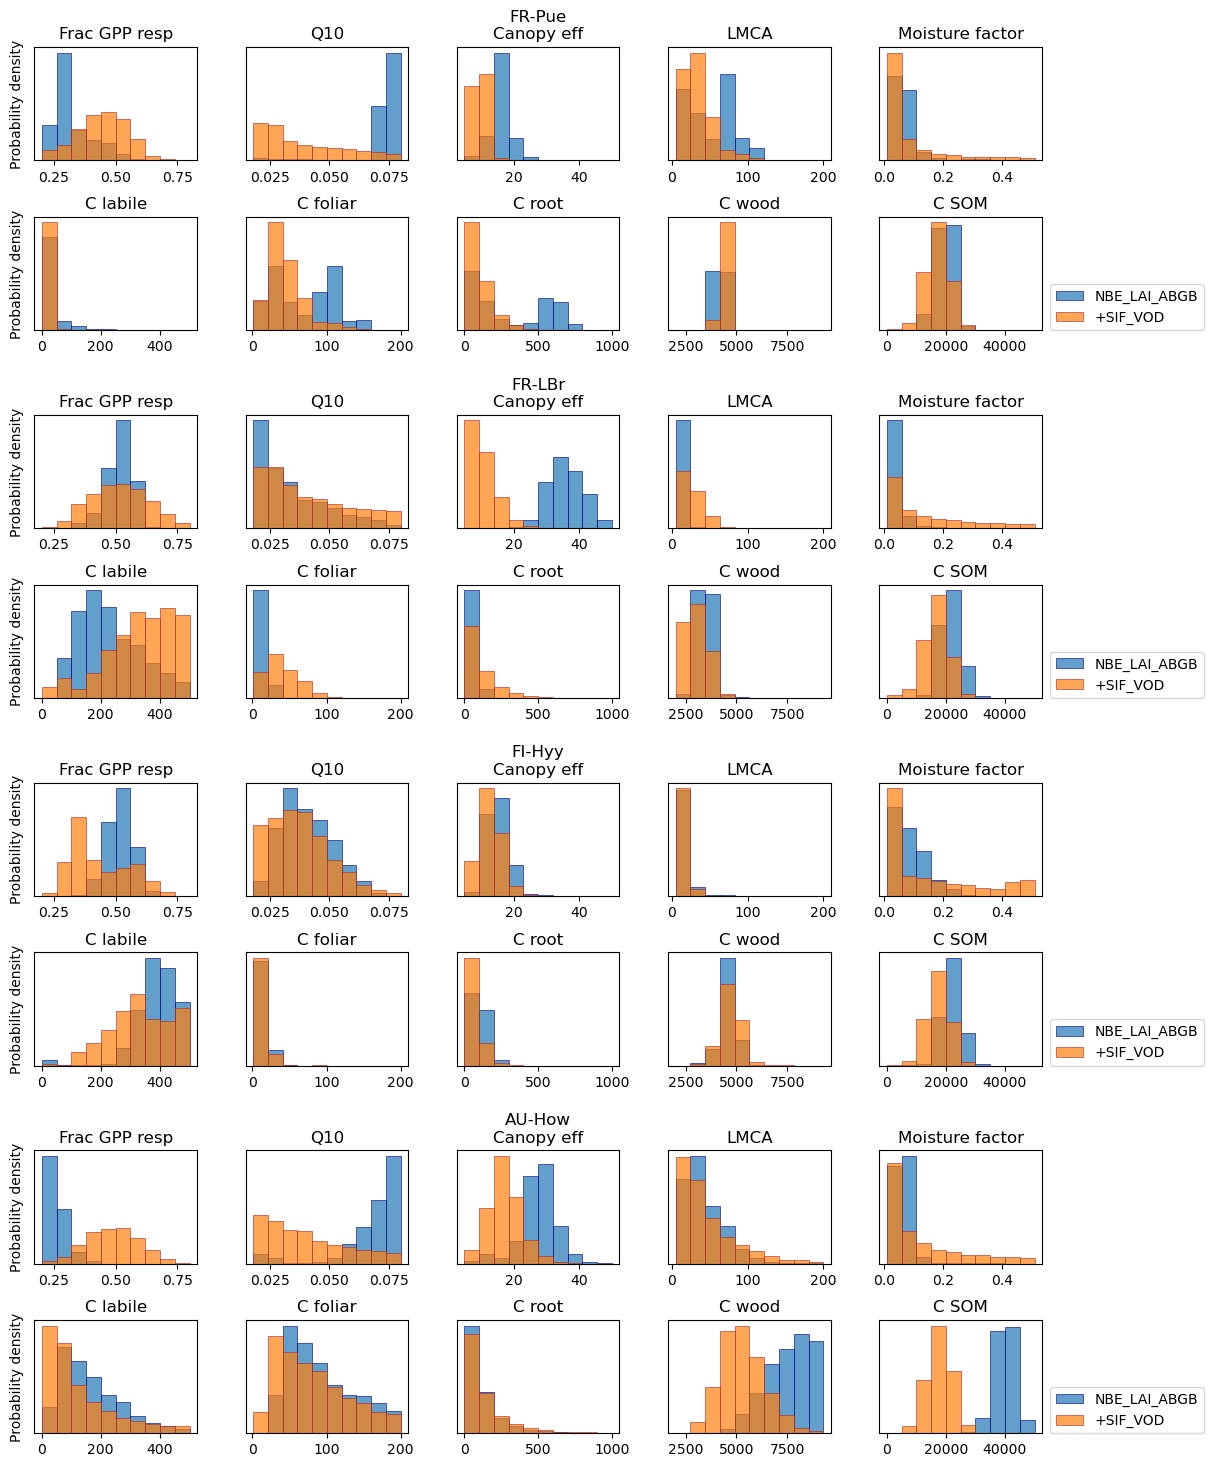

In [98]:
six_ = ['FR-Pue', 'FR-LBr', 'FI-Hyy', 'AU-How']
fig = plt.figure(figsize=(13, 18))

outer_grid = fig.add_gridspec(4, 1, wspace=0.0, hspace=0.3)
param = ['Frac GPP resp', 'Q10', 'Canopy eff', 'LMCA', 'Moisture factor', 'C labile', 'C foliar', 'C root', 'C wood' , 'C SOM']
labels = ['NBE_LAI_ABGB', '+SIF_VOD']

for nnn, base in enumerate(six_):
    
    cbr_default = rwbin.read_cbr_file(dir_cbr + base +'N_L_B-0.cbr', INFO = INFO)
    cbr_SIF = rwbin.read_cbr_file(dir_cbr+ base +'SIF_VOD-0.cbr', INFO = INFO2)
 
    #ax = fig.add_subplot(4, 1, nnn+1)
    #parameter_hist_compare(list_n, cbr_default, cbr_SIF, i, ['NBE_LAI_ABGB', '+SIF_VOD'], base, outer_grid, nnn)
    #plt.savefig('FRPue_param_v1.pdf', bbox_inches='tight')
    #outer_subplot = fig.add_subplot(outer_grid[nnn])
    #outer_subplot.set_title(six_[nnn])

    inner_grid = outer_grid[nnn, 0].subgridspec(2, 5, wspace=0.3, hspace=0.5)
    axs = inner_grid.subplots()  # Create all subplots for the inner grid.

    for (c, d), ax in np.ndenumerate(axs):
        ind = 5*c +d
    #for ind, parname in enumerate(i):
        index = i[ind]

        ax.hist(cbr_default[:,index], bins=ranges.iloc[:,ind], density = True, alpha = 0.7, edgecolor='navy', linewidth=0.6,  label = labels[0])
        ax.hist(cbr_SIF[:,index], bins=ranges.iloc[:,ind], density = True, alpha = 0.7, edgecolor='brown', linewidth=0.6,  label = labels[1])
        
        ax.set_yticks([]) 
        if ind == 2:
            ax.set_title(six_[nnn]+ '\n' + param[ind])
        else:
            ax.set_title(param[ind]) 
        if ind ==0 or ind == 5:
            ax.set_ylabel('Probability density')
    ax.legend(bbox_to_anchor=(1.05, 0), loc='lower left', borderaxespad=0.)
     
    #plt.suptitle(base)    
plt.savefig('four_param.pdf', bbox_inches='tight')


In [36]:
ranges = pd.DataFrame({'r1' : np.arange(0.2, 0.8, 0.06), 'r2' : np.arange(0.018, 0.081, (0.08-0.018)/10), 
                      'r3': np.arange(5, 50.1, 4.5), 'r4': np.arange(5, 200.1, 19.5), 'r9': np.arange(0.01, 1.01, 0.099 ),
                       'r5': np.arange(1, 2000.1, 199.9 ),
                      'r6': np.arange(1, 200.1, 19.9 ), 'r7': np.arange(1, 1000.1, 99.9 ), 
                       #'r8': np.arange(2000, 7000.1, 454.6 ),
                       'r8': np.arange(5000, 20000.1, 1363.7 ),
                       'r10': np.arange(1, 50000.1, 4999.9 )})

In [37]:
ranges = pd.DataFrame({'r1' : np.arange(0.2, 0.8, 0.06), 'r2' : np.arange(0.018, 0.081, (0.08-0.018)/10), 
                      'r3': np.arange(5, 50.1, 4.5), 'r4': np.arange(5, 200.1, 19.5), 'r9': np.arange(0.01, 1.01, 0.099 ),
                       'r5': np.arange(1, 2000.1, 199.9 ),
                      'r6': np.arange(1, 500.1, 49.9 ), 'r7': np.arange(1, 2000.1, 199.9 ), 
                       #'r8': np.arange(2000, 7000.1, 454.6 ),
                       'r8': np.arange(5000, 20000.1, 1363.7 ),
                       'r10': np.arange(1, 50000.1, 4999.9 )})

In [27]:
ranges = pd.DataFrame({'r1' : np.arange(0.2, 0.8, 0.06), 'r2' : np.arange(0.018, 0.081, (0.08-0.018)/10), 
                      'r3': np.arange(5, 50.1, 4.5), 'r4': np.arange(5, 200.1, 19.5), 'r9': np.arange(0.01, 1.01, 0.099 ),
                       'r5': np.arange(1, 2000.1, 199.9 ),
                      'r6': np.arange(1, 2000.1, 199.9 ), 'r7': np.arange(1, 2000.1, 199.9 ), 
                       #'r8': np.arange(2000, 7000.1, 454.6 ),
                       'r8': np.arange(1, 100000.1, 9999.1 ),
                       'r10': np.arange(1, 200000.1, 19999.9 )})

In [26]:
len(np.arange(0.01, 1.01, 0.099 ))

11

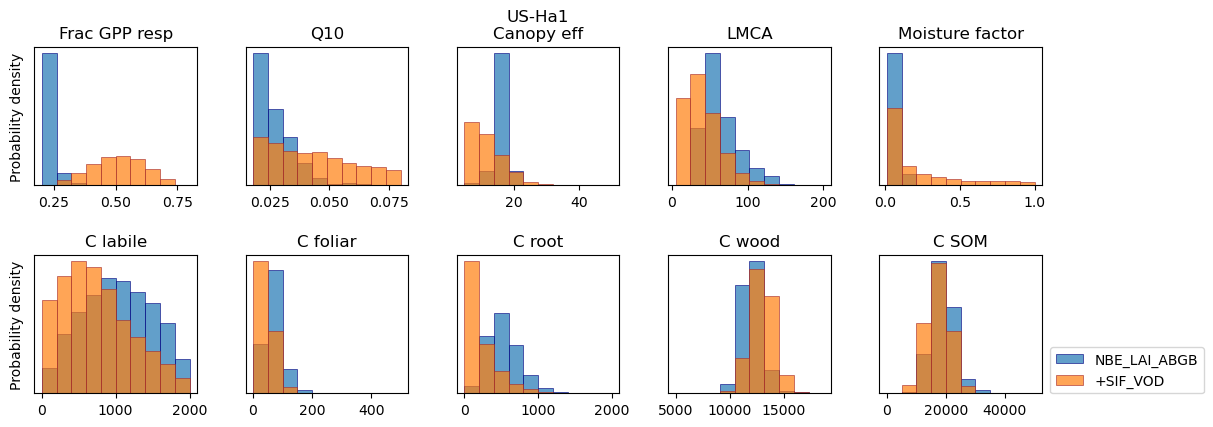

In [42]:
six_ = ['US-Ha1' ]
fig = plt.figure(figsize=(13, 4.5))

outer_grid = fig.add_gridspec(1, 1, wspace=0.0, hspace=0.3)
param = ['Frac GPP resp', 'Q10', 'Canopy eff', 'LMCA', 'Moisture factor', 'C labile', 'C foliar', 'C root', 'C wood' , 'C SOM']
labels = ['NBE_LAI_ABGB', '+SIF_VOD']

for nnn, base in enumerate(six_):
    
    cbr_default = rwbin.read_cbr_file(dir_cbr + base +'N_L_B-0.cbr', INFO = INFO)
    cbr_SIF = rwbin.read_cbr_file(dir_cbr+ base +'SIF_VOD-0.cbr', INFO = INFO2)
 
    #ax = fig.add_subplot(4, 1, nnn+1)
    #parameter_hist_compare(list_n, cbr_default, cbr_SIF, i, ['NBE_LAI_ABGB', '+SIF_VOD'], base, outer_grid, nnn)
    #plt.savefig('FRPue_param_v1.pdf', bbox_inches='tight')
    #outer_subplot = fig.add_subplot(outer_grid[nnn])
    #outer_subplot.set_title(six_[nnn])

    inner_grid = outer_grid[nnn, 0].subgridspec(2, 5, wspace=0.3, hspace=0.5)
    axs = inner_grid.subplots()  # Create all subplots for the inner grid.

    for (c, d), ax in np.ndenumerate(axs):
        ind = 5*c +d
    #for ind, parname in enumerate(i):
        index = i[ind]

        ax.hist(cbr_default[:,index], bins=ranges.iloc[:,ind], density = True, alpha = 0.7, edgecolor='navy', linewidth=0.6,  label = labels[0])
        ax.hist(cbr_SIF[:,index], bins=ranges.iloc[:,ind], density = True, alpha = 0.7, edgecolor='brown', linewidth=0.6,  label = labels[1])
        
        ax.set_yticks([]) 
        if ind == 2:
            ax.set_title(six_[nnn]+ '\n' + param[ind])
        else:
            ax.set_title(param[ind]) 
        if ind ==0 or ind == 5:
            ax.set_ylabel('Probability density')
    ax.legend(bbox_to_anchor=(1.05, 0), loc='lower left', borderaxespad=0.)
     
    #plt.suptitle(base)    
plt.savefig('US_param_v1.pdf', bbox_inches='tight')


/Users/olyaskulovich/miniconda3/lib/python3.9/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


AttributeError: module 'matplotlib.pyplot' has no attribute 'set_title'

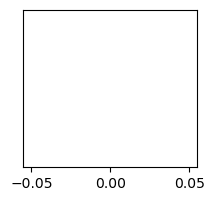

In [41]:
base = "US-Ha1"
fig = plt.figure(figsize=(13, 4.5))

param = ['Frac GPP resp', 'Q10', 'Canopy eff', 'LMCA', 'Moisture factor', 'C labile', 'C foliar', 'C root', 'C wood' , 'C SOM']
labels = ['NBE_LAI_ABGB', '+SIF+VOD']

    
cbr_default = rwbin.read_cbr_file(dir_cbr + base +'N_L_B-0.cbr', INFO = INFO)
cbr_SIF = rwbin.read_cbr_file(dir_cbr+ base +'SIF_VOD-0.cbr', INFO = INFO2)
 

for ind, parname in enumerate(param):

    plt.subplot(2,5, ind+1)


    plt.hist(cbr_default[:,index], bins=ranges.iloc[:,ind], density = True, alpha = 0.7, edgecolor='navy', linewidth=0.6,  label = labels[0])
    plt.hist(cbr_SIF[:,index], bins=ranges.iloc[:,ind], density = True, alpha = 0.7, edgecolor='brown', linewidth=0.6,  label = labels[1])
        
    plt.yticks([]) 

    plt.set_title(param[ind]) 
    if ind ==0 or ind == 5:
        plt.ylabel('Probability density')
    plt.legend(bbox_to_anchor=(1.05, 0), loc='lower left', borderaxespad=0.)
     
    #plt.suptitle(base)    
#plt.savefig('four_param.pdf', bbox_inches='tight')
plt.show()

In [5]:
INFO2 = {'nopars':36, 'latterhalf':0}
INFO = {'nopars':33, 'latterhalf':0}
#cbr_default = rwbin.read_cbr_file(dir_cbr +'US-Ha1N_L_B-0.cbr', INFO = INFO)
#cbr_default = rwbin.read_cbr_file(dir_cbr+'FI-HyyABGB_LAI_NBE-1.cbr', INFO = INFO)


#cbr_SIF = rwbin.read_cbr_file(dir_cbr+'US-Ha1edc-6.cbr', INFO = INFO2)



In [9]:
#cbf_load = rwbin.read_cbf_file(new_cbf)
modelid = 895#int(cbf_load['ID'])
parameter_names = readcardamommodel.get_parnames(modelid,output='shortnames')

#INFO = {'nopars':33, 'latterhalf':0}
#INFO2 = {'nopars':36, 'latterhalf':0}


#cbr_load = rwbin.read_cbr_file(cardamom_cbr,INFO = INFO)
i = [1, 9, 10,  16, 32, 17, 18, 19, 20,  22]
#i = range(1, 36)
#i = [1, 9, 10,  16, 32, 17, 18, 33, 34,  35]

list_n = [parameter_names[x] for x in i]



In [54]:
list_n

['fgpp_r',
 'q10',
 'canopy_eff',
 'lmca',
 'moisture_factor',
 'c_labile',
 'c_foliar',
 'c_root',
 'c_wood',
 'c_som']

In [33]:
parameter_names

['decomp_rate',
 'fgpp_r',
 'fgpp_to_foliage',
 'fgpp_to_roots',
 'leaf_lifespan',
 'tor_wood',
 'tor_root',
 'tor_litter',
 'tor_som',
 'q10',
 'canopy_eff',
 'bday',
 'f_to_clab',
 'clab_rperiod',
 'fday',
 'leaf_fperiod',
 'lmca',
 'c_labile',
 'c_foliar',
 'c_root',
 'c_wood',
 'c_litter',
 'c_som',
 'iwue',
 'runoff_fpt',
 'wilt_pt',
 'bucket_t0',
 'folia_biomass_cf',
 'ligneous_biomass_cf',
 'dom_cf',
 'res_fac',
 'lab_lifespan',
 'moisture_factor',
 'sif_c',
 'vod_a',
 'vod_b']

In [5]:
list_flux = ['FLX_US-Ha1_FLUXNET2015.csv',  'FLX_FR-Pue_FLUXNET2015.csv',  'FLX_FR-LBr_FLUXNET2015.csv', 'FLX_FI-Hyy_FLUXNET2015.csv',  'FLX_AU-How_FLUXNET2015.csv']

nc = 0
flux_data = pd.read_csv(list_flux[nc])
flux_data['TIMESTAMP'] = pd.to_datetime(flux_data['TIMESTAMP'], format='%Y%m')

In [6]:
lai_cbr = ['US-Ha1811_exp_uncopt', 'nothing', 'FR-Pue811_exp_uncopt', 'FR-LBr811_exp_uncopt',  'FI-Hyy811_exp_uncopt', 'AU-How811_exp_uncopt' ]
laivod_cbr = ['US-Ha1SIF+VOD', 'nothing', 'FR-PueSIF+VOD', 'FR-LBrSIF+VOD', 'FI-HyySIF+VOD', 'AU-HowSIF+VOD'   ]

basename = lai_cbr[nc][:6]
i=6
cbf_default = dir_cbf + basename +'new_data.cbf'
cbf_SIF = dir_cbf +  laivod_cbr[nc] + '.cbf'
chain = 6
cbr_default = dir_cbr +  lai_cbr[nc] +'-'+ str(i)+ '.cbr'
CBR_default = pC.forward_run(dircardamom, dir_output, dir_cbr, cbf_default, cbr_default, chain )
         
cbr_SIF = dir_cbr + laivod_cbr[nc]  +'-'+ str(i)+ '.cbr' 
CBR_sif = pC.forward_run(dircardamom, dir_output, dir_cbr, cbf_SIF, cbr_SIF, chain )
    

OKCHECK:CHECK: DATA structure successfully initialized
about to declare EDCD
DALECmodel.EDCD = 0x0
EDCD->EQF = 2.00
done with declaration
DALECmodel.EDCD->EQF = 2.00
DATA->nodays = 180
DATA->nofluxes = 30
nee annual unc = -9999.000000
nee obs unc = 1.000000
lai other prior = -9999.000000
lai other unc = 0.568798
reading file...
No prescribed met reference means, calculating based on driver data
frf = 0
***CBF FILE SUMMARY***MODEL ID = 811
No days = 180
Mean Rad = 13.245573
Mean Temp = 8.297143
Mean Prec = 3.241389
Latitude = 43.000000
Number of MET drivers9
Number of GPP obs. = 0
Number of LAI obs. = 151
Number of NEE obs. = 156
Number of EWT obs. = 0
Number of CH4 obs. = 0
Number of SIF obs. = 0
Number of VOD obs. = 0
Number of obs. = 13
Ecological & Dynamic Constraints options
EDC likelihood option = 1
EDC diagnostics option = 0
*****END OF CBF FILE SUMMARY***number of parvecs to run = 10000
The exit code was: 0
OKCHECK:CHECK: DATA structure successfully initialized
about to declare 

In [7]:
lb_F = CBR_default['POOLS'][:,:,poolnames.index('Labile C')]
lbd_F = CBR_sif['POOLS'][:,:,poolnames.index('Labile C')]

Fol_F = CBR_default['POOLS'][:,:,poolnames.index('Foliar C')]
Rt_F = CBR_default['POOLS'][:,:,poolnames.index('Root C')]
Wd_F = CBR_default['POOLS'][:,:,poolnames.index('Wood C')]
Fl_F = CBR_default['POOLS'][:,:,poolnames.index('Fine litter C')]
Som_F = CBR_default['POOLS'][:,:,poolnames.index('Soil organic matter (SOM) C')]
Fold_F = CBR_sif['POOLS'][:,:,poolnames.index('Foliar C')]
Rtd_F = CBR_sif['POOLS'][:,:,poolnames.index('Root C')]
Wdd_F = CBR_sif['POOLS'][:,:,poolnames.index('Wood C')]
Fld_F = CBR_sif['POOLS'][:,:,poolnames.index('Fine litter C')]
Somd_F = CBR_sif['POOLS'][:,:,poolnames.index('Soil organic matter (SOM) C')]

In [8]:
for i in range(10): 
    cbr_default = dir_cbr + lai_cbr[nc] +'-'+ str(i)+ '.cbr'  #  'FR-PueLAI-''US-Ha1LAI-' 'FI-HyynoNBEhalfLAI811-' 
    CBR_default = pC.forward_run(dircardamom, dir_output, dir_cbr, cbf_default, cbr_default, chain )
         
    cbr_SIF = dir_cbr + laivod_cbr[nc]  +'-' + str(i)+ '.cbr'# 'FR-PueVOD_synth-' #'US-Ha1VOD_synth-' ''FI-HyyhalfLAI+SIF_synth-''
    CBR_sif = pC.forward_run(dircardamom, dir_output, dir_cbr, cbf_SIF, cbr_SIF, chain )
    lb_F = np.concatenate((lb_F, CBR_default['POOLS'][:,:,poolnames.index('Labile C')]))
    lbd_F = np.concatenate((lbd_F, CBR_sif['POOLS'][:,:,poolnames.index('Labile C')]))

    Fol_F = np.concatenate((Fol_F, CBR_default['POOLS'][:,:,poolnames.index('Foliar C')]))
    Rt_F = np.concatenate((Rt_F, CBR_default['POOLS'][:,:,poolnames.index('Root C')]))
    Wd_F = np.concatenate((Wd_F, CBR_default['POOLS'][:,:,poolnames.index('Wood C')]))
    Fl_F = np.concatenate((Fl_F, CBR_default['POOLS'][:,:,poolnames.index('Fine litter C')]))
    Som_F = np.concatenate(( Som_F , CBR_default['POOLS'][:,:,poolnames.index('Soil organic matter (SOM) C')]))
    Fold_F = np.concatenate((Fold_F, CBR_sif['POOLS'][:,:,poolnames.index('Foliar C')]))
    Rtd_F = np.concatenate((Rtd_F, CBR_sif['POOLS'][:,:,poolnames.index('Root C')]))
    Wdd_F = np.concatenate((Wdd_F, CBR_sif['POOLS'][:,:,poolnames.index('Wood C')]))
    Fld_F = np.concatenate((Fld_F, CBR_sif['POOLS'][:,:,poolnames.index('Fine litter C')]))
    Somd_F = np.concatenate( (Somd_F , CBR_sif['POOLS'][:,:,poolnames.index('Soil organic matter (SOM) C')]))
    

OKCHECK:CHECK: DATA structure successfully initialized
about to declare EDCD
DALECmodel.EDCD = 0x0
EDCD->EQF = 2.00
done with declaration
DALECmodel.EDCD->EQF = 2.00
DATA->nodays = 180
DATA->nofluxes = 30
nee annual unc = -9999.000000
nee obs unc = 1.000000
lai other prior = -9999.000000
lai other unc = 0.568798
reading file...
No prescribed met reference means, calculating based on driver data
frf = 0
***CBF FILE SUMMARY***MODEL ID = 811
No days = 180
Mean Rad = 13.245573
Mean Temp = 8.297143
Mean Prec = 3.241389
Latitude = 43.000000
Number of MET drivers9
Number of GPP obs. = 0
Number of LAI obs. = 151
Number of NEE obs. = 156
Number of EWT obs. = 0
Number of CH4 obs. = 0
Number of SIF obs. = 0
Number of VOD obs. = 0
Number of obs. = 13
Ecological & Dynamic Constraints options
EDC likelihood option = 1
EDC diagnostics option = 0
*****END OF CBF FILE SUMMARY***number of parvecs to run = 10000
The exit code was: 0
OKCHECK:CHECK: DATA structure successfully initialized
about to declare 

OKCHECK:CHECK: DATA structure successfully initialized
about to declare EDCD
DALECmodel.EDCD = 0x0
EDCD->EQF = 2.00
done with declaration
DALECmodel.EDCD->EQF = 2.00
DATA->nodays = 180
DATA->nofluxes = 30
nee annual unc = -9999.000000
nee obs unc = 1.000000
lai other prior = -9999.000000
lai other unc = 0.568798
reading file...
No prescribed met reference means, calculating based on driver data
frf = 0
***CBF FILE SUMMARY***MODEL ID = 895
No days = 180
Mean Rad = 13.245573
Mean Temp = 8.297143
Mean Prec = 3.241389
Latitude = 43.000000
Number of MET drivers9
Number of GPP obs. = 0
Number of LAI obs. = 151
Number of NEE obs. = 0
Number of EWT obs. = 0
Number of CH4 obs. = 0
Number of SIF obs. = 180
Number of VOD obs. = 113
Number of obs. = 13
Ecological & Dynamic Constraints options
EDC likelihood option = 1
EDC diagnostics option = 0
*****END OF CBF FILE SUMMARY***number of parvecs to run = 10000
The exit code was: 0


In [9]:
def plot_median_quant( data, data_d, flux_data):
    plt.plot(flux_data['TIMESTAMP'], np.median(data,axis=0), linewidth=1.5, alpha = 1, color='navy',label='base')
    plt.plot(flux_data['TIMESTAMP'], np.median(data_d,axis=0),linewidth=1.5, alpha = 1, color='maroon',label='+SIF+VODs')
    plt.fill_between(flux_data['TIMESTAMP'], np.quantile(data, 0.25, axis=0), np.quantile(data, 0.75, axis=0), alpha = 0.35, color='navy', edgecolor='none')
    plt.fill_between(flux_data['TIMESTAMP'], np.quantile(data_d, 0.25, axis=0), np.quantile(data_d, 0.75, axis=0), alpha = 0.35, color='orange', edgecolor='none')


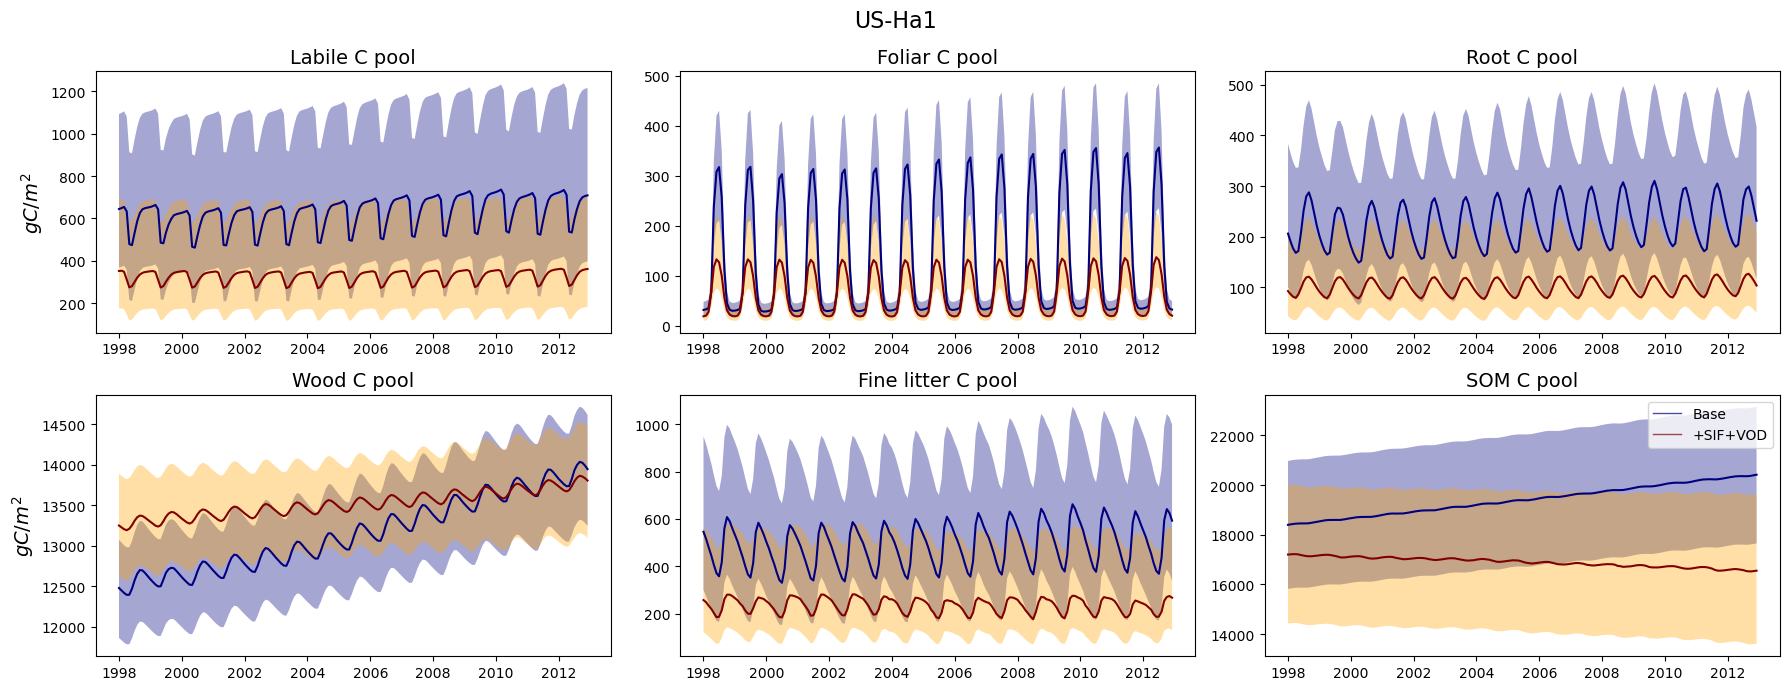

In [10]:
fig = plt.figure(figsize=(18, 7))
   

ax = fig.add_subplot(2, 3, 1)

plot_median_quant( lb_F, lbd_F, flux_data)

ax.set_ylabel('$gC/m^2$', size=14)
#ax.set_xlabel('Time [months]')
plt.title('Labile C pool', size=14)


ax = fig.add_subplot(2, 3, 2)

plot_median_quant( Fol_F, Fold_F, flux_data)

#ax.set_ylabel(, $gC/m^2$')
#ax.set_xlabel('Time [months]')
plt.title('Foliar C pool', size=14)
              
ax = fig.add_subplot(2, 3, 3)

plot_median_quant( Rt_F, Rtd_F, flux_data)

#ax.set_ylabel(, $gC/m^2$')
#ax.set_xlabel('Time [months]')
plt.title('Root C pool', size=14)
              
ax = fig.add_subplot(2, 3, 4)

plot_median_quant( Wd_F, Wdd_F, flux_data)

ax.set_ylabel('$gC/m^2$', size=14)
#ax.set_xlabel('Time [months]')
plt.title('Wood C pool', size=14)
              
ax = fig.add_subplot(2, 3, 5)
plot_median_quant( Fl_F, Fld_F, flux_data)

#ax.set_ylabel(, $gC/m^2$')
#ax.set_xlabel('Time [months]')
plt.title('Fine litter C pool', size=14)
    
ax = fig.add_subplot(2, 3, 6)
plot_median_quant( Som_F, Somd_F, flux_data)


#ax.set_ylabel('$gC/m^2$' )
#ax.set_xlabel('Time [months]')
plt.title('SOM C pool', size=14)
from matplotlib.lines import Line2D

custom_lines = [Line2D([0], [0], color='navy', alpha = 0.7, lw=1),
            Line2D([0], [0], color='maroon', alpha = 0.7, lw=1)]


plt.legend( custom_lines, ['Base', '+SIF+VOD'], loc="upper right")

plt.suptitle(basename, size=16)
fig.tight_layout()
#plt.savefig(basename+ '_pools.png', dpi = 300, bbox_inches='tight')
plt.show()